In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import shap
import optuna

from processing_functions import *

random_state = 42

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', None)  # Show full strings in columns

X_trainval, y_trainval, X_test, description, description_X_trainval, numerical_vars, cat_vars, binary_vars = load_data()

print("# training+validation obs: ", X_trainval.shape[0])
print("# test obs: ", X_test.shape[0])
print("# features", X_test.shape[1])

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['CODE_GENDER'] = X['CODE_GENDER'].replace({'M': 1, 'F': 0, 'XNA': np.nan})
/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['CODE_GENDER'] = X['CODE_GENDER'].replace({'M': 1, 'F': 0, 'XNA': np.nan})


# training+validation obs:  307511
# test obs:  48744
# features 120


In [13]:
print(description[description.Feature=='TARGET'].Description.values[0])
vc = y_trainval.value_counts(dropna=False)
pct = (vc / len(y_trainval)) * 100
display(pd.DataFrame({'count': vc, 'percent': pct.round(2)}))

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)


,count,percent
TARGET,,
0,282686,91.93
1,24825,8.07


In [14]:
description_X_trainval[description_X_trainval.TYPE=='BINARY']

,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,,int64,BINARY,2,0,0.0
2,FLAG_OWN_CAR,Flag if the client owns a car,,int64,BINARY,2,0,0.0
3,FLAG_OWN_REALTY,Flag if client owns a house or flat,,int64,BINARY,2,0,0.0
20,FLAG_MOBIL,"Did client provide mobile phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
21,FLAG_EMP_PHONE,"Did client provide work phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
22,FLAG_WORK_PHONE,"Did client provide home phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
23,FLAG_CONT_MOBILE,"Was mobile phone reachable (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
24,FLAG_PHONE,"Did client provide home phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
25,FLAG_EMAIL,"Did client provide email (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
32,REG_REGION_NOT_LIVE_REGION,"Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)",,int64,BINARY,2,0,0.0


In [15]:
display(description_X_trainval.TYPE.value_counts())
description_X_trainval.to_csv("data/preprocessed/description_training_set.csv", index=False)
description_X_trainval#.sort_values(['TYPE', 'NaN count'], ascending=[True, False])

TYPE
NUMERIC        73
BINARY         35
CATEGORICAL    12
Name: count, dtype: int64

,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,,int64,BINARY,2,0,0.00
1,CODE_GENDER,Gender of the client,,float64,NUMERIC,2,4,0.00
2,FLAG_OWN_CAR,Flag if the client owns a car,,int64,BINARY,2,0,0.00
3,FLAG_OWN_REALTY,Flag if client owns a house or flat,,int64,BINARY,2,0,0.00
4,CNT_CHILDREN,Number of children the client has,,int64,NUMERIC,15,0,0.00
5,AMT_INCOME_TOTAL,Income of the client,,float64,NUMERIC,2548,0,0.00
6,AMT_CREDIT,Credit amount of the loan,,float64,NUMERIC,5603,0,0.00
7,AMT_ANNUITY,Loan annuity,,float64,NUMERIC,13672,12,0.00
8,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,,float64,NUMERIC,1002,278,0.09
9,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,,object,CATEGORICAL,7,1292,0.42


In [16]:
for col in cat_vars:
    print(f"{col}: {description[description.Feature==col].Description}")
    vc = X_trainval[col].value_counts(dropna=False)
    pct = (vc / len(X_trainval)) * 100
    display(pd.DataFrame({'count': vc, 'percent': pct.round(2)}))

NAME_TYPE_SUITE: 11    Who was accompanying client when he was applying for the loan
Name: Description, dtype: object


,count,percent
NAME_TYPE_SUITE,,
Unaccompanied,248526,80.82
Family,40149,13.06
"Spouse, partner",11370,3.70
Children,3267,1.06
Other_B,1770,0.58
NaN,1292,0.42
Other_A,866,0.28
Group of people,271,0.09


NAME_INCOME_TYPE: 12    Clients income type (businessman, working, maternity leave,ï¿½)
Name: Description, dtype: object


,count,percent
NAME_INCOME_TYPE,,
Working,158774,51.63
Commercial associate,71617,23.29
Pensioner,55362,18.00
State servant,21703,7.06
Unemployed,22,0.01
Student,18,0.01
Businessman,10,0.00
Maternity leave,5,0.00


NAME_EDUCATION_TYPE: 13    Level of highest education the client achieved
Name: Description, dtype: object


,count,percent
NAME_EDUCATION_TYPE,,
Secondary / secondary special,218391,71.02
Higher education,74863,24.34
Incomplete higher,10277,3.34
Lower secondary,3816,1.24
Academic degree,164,0.05


NAME_FAMILY_STATUS: 14    Family status of the client
Name: Description, dtype: object


,count,percent
NAME_FAMILY_STATUS,,
Married,196432,63.88
Single / not married,45444,14.78
Civil marriage,29775,9.68
Separated,19770,6.43
Widow,16088,5.23
NaN,2,0.00


NAME_HOUSING_TYPE: 15    What is the housing situation of the client (renting, living with parents, ...)
Name: Description, dtype: object


,count,percent
NAME_HOUSING_TYPE,,
House / apartment,272868,88.73
With parents,14840,4.83
Municipal apartment,11183,3.64
Rented apartment,4881,1.59
Office apartment,2617,0.85
Co-op apartment,1122,0.36


OCCUPATION_TYPE: 28    What kind of occupation does the client have
Name: Description, dtype: object


,count,percent
OCCUPATION_TYPE,,
NaN,96391,31.35
Laborers,55186,17.95
Sales staff,32102,10.44
Core staff,27570,8.97
Managers,21371,6.95
Drivers,18603,6.05
High skill tech staff,11380,3.70
Accountants,9813,3.19
Medicine staff,8537,2.78


WEEKDAY_APPR_PROCESS_START: 32    On which day of the week did the client apply for the loan
Name: Description, dtype: object


,count,percent
WEEKDAY_APPR_PROCESS_START,,
TUESDAY,53901,17.53
WEDNESDAY,51934,16.89
MONDAY,50714,16.49
THURSDAY,50591,16.45
FRIDAY,50338,16.37
SATURDAY,33852,11.01
SUNDAY,16181,5.26


ORGANIZATION_TYPE: 40    Type of organization where client works
Name: Description, dtype: object


,count,percent
ORGANIZATION_TYPE,,
Business Entity Type 3,67992,22.11
NaN,55374,18.01
Self-employed,38412,12.49
Other,16683,5.43
Medicine,11193,3.64
Business Entity Type 2,10553,3.43
Government,10404,3.38
School,8893,2.89
Trade: type 7,7831,2.55


FONDKAPREMONT_MODE: 86    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
FONDKAPREMONT_MODE,,
NaN,210295,68.39
reg oper account,73830,24.01
reg oper spec account,12080,3.93
not specified,5687,1.85
org spec account,5619,1.83


HOUSETYPE_MODE: 87    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
HOUSETYPE_MODE,,
NaN,154297,50.18
block of flats,150503,48.94
specific housing,1499,0.49
terraced house,1212,0.39


WALLSMATERIAL_MODE: 89    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
WALLSMATERIAL_MODE,,
NaN,156341,50.84
Panel,66040,21.48
"Stone, brick",64815,21.08
Block,9253,3.01
Wooden,5362,1.74
Mixed,2296,0.75
Monolithic,1779,0.58
Others,1625,0.53


EMERGENCYSTATE_MODE: 90    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
EMERGENCYSTATE_MODE,,
No,159428,51.84
NaN,145755,47.40
Yes,2328,0.76


In [17]:
X_trainval = feature_engineering(X_trainval, additional_features=True)
X_test = feature_engineering(X_test, additional_features=True)

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['NAME_EDUCATION_TYPE_ORDINAL'] = X['NAME_EDUCATION_TYPE'].replace(education_order).astype('int64')
/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:64: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X['NAME_EDUCATION_TYPE_ORDINAL'] = X['NAME_EDUCATION_TYPE'].replace(education_order).astype('int64')
/Users/fdd838/Library/C

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=random_state, stratify=y_trainval)

scale_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"Class Imbalance Ratio (scale_pos_weight): {scale_weight:.2f}")

FIXED_PARAMS =  {
    # Fixed parameters
    "booster": "gbtree",
    "tree_method": "hist",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "device": "cuda",
    "verbosity": 0,
    'seed': random_state,
    'max_cat_to_onehot': 1
}

INITIAL_PARAMS = {
    'scale_pos_weight': scale_weight,
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # L1 regularization
    'reg_lambda': 1,  # L2 regularization
    'min_child_weight': 1,
}

params = INITIAL_PARAMS.copy()
params.update(FIXED_PARAMS)

Class Imbalance Ratio (scale_pos_weight): 11.39


Best Iteration: 88
Best CV AUC: 0.75853 +/- 0.00375
AUC on validation_set: 0.76297


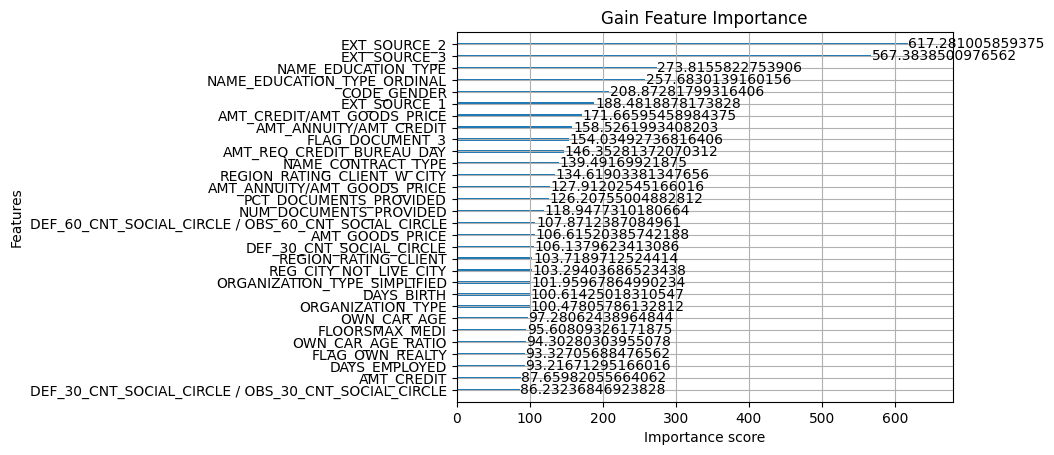

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:228: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


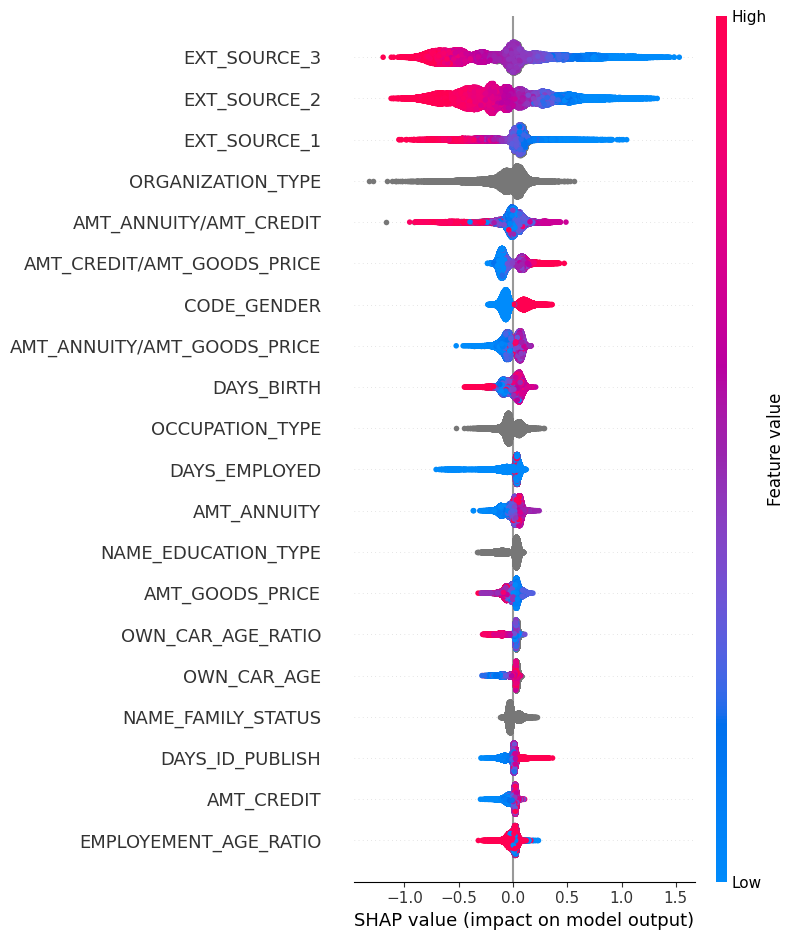

In [19]:
importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval, 
    y_trainval=y_trainval,
    X_train=X_train, 
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test, 
    submission_name="submission1", 
    seed=random_state,
    nfold=5, 
    num_boost_round=1000, 
    early_stopping_rounds=10,
    stratified=True, 
    metrics="auc",
)

In [20]:
#get_ordered_importance(importance)
shap_importance = get_ordered_shap_importance(X_val, shap_values)
shap_importance

,Feature,shap_importance,%shap_importance,CUMSUM %shap_importance
0,EXT_SOURCE_3,0.395722,15.773376,15.773376
1,EXT_SOURCE_2,0.347248,13.841231,29.614609
2,EXT_SOURCE_1,0.154206,6.146605,35.761215
3,ORGANIZATION_TYPE,0.112517,4.484879,40.246094
4,AMT_ANNUITY/AMT_CREDIT,0.101218,4.034512,44.280605
5,AMT_CREDIT/AMT_GOODS_PRICE,0.099718,3.974733,48.255337
6,CODE_GENDER,0.089746,3.577269,51.832603
7,AMT_ANNUITY/AMT_GOODS_PRICE,0.066846,2.664463,54.497066
8,DAYS_BIRTH,0.063382,2.526399,57.023464
9,OCCUPATION_TYPE,0.057849,2.305836,59.329300


Best Iteration: 114
Best CV AUC: 0.75881 +/- 0.00416
AUC on validation_set: 0.76453


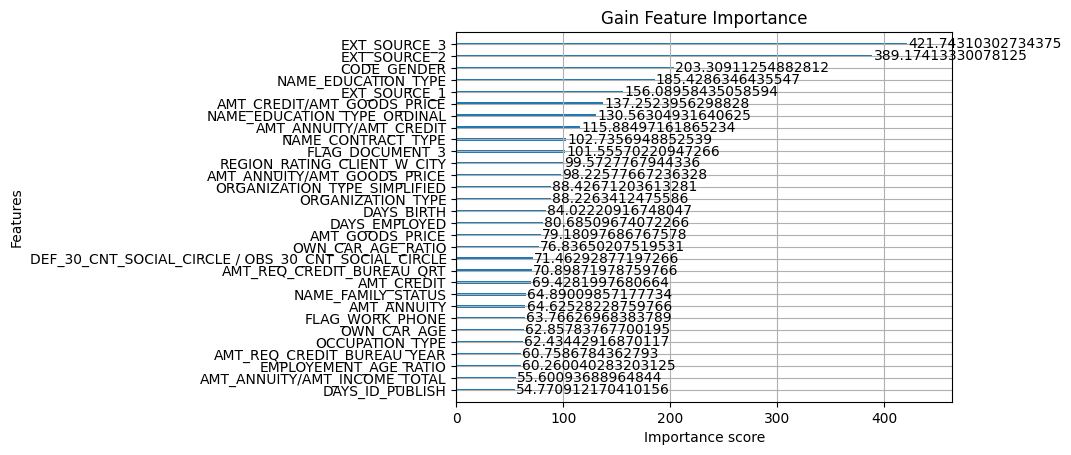

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:228: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


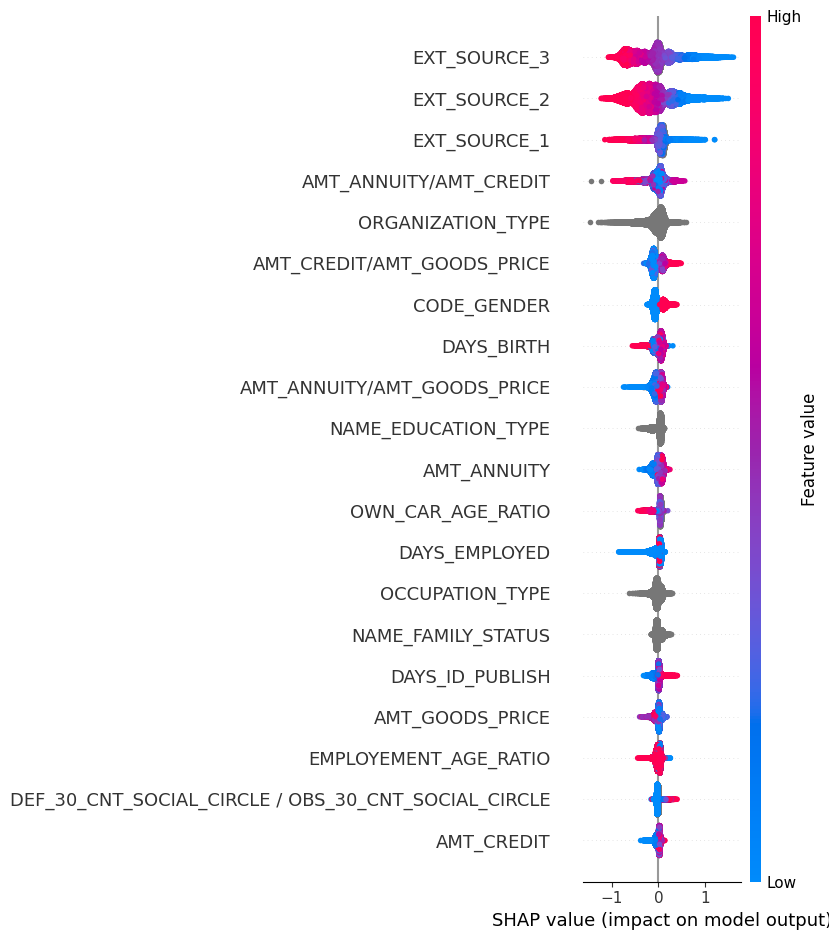

In [21]:
to_keep = shap_importance.iloc[:35].Feature.tolist()
importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval[to_keep], 
    y_trainval=y_trainval,
    X_train=X_train[to_keep], 
    y_train=y_train,
    X_val=X_val[to_keep],
    y_val=y_val,
    X_test=X_test[to_keep], 
    submission_name="submission2", 
    seed=random_state,
    nfold=5, 
    num_boost_round=1000, 
    early_stopping_rounds=10,
    stratified=True, 
    metrics="auc",
)

In [24]:
def objective(trial):

    optuna_params = {
        # Tuned parameters
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 100.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 100.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 5.0, 15.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
    }
    optuna_params.update(FIXED_PARAMS)

    n_estimators = 500

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=trial.number) # use trial.number for different splits per trial
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train[to_keep], y_train)):
        X_train_optuna, X_val_optuna = X_train[to_keep].iloc[train_idx], X_train[to_keep].iloc[val_idx]
        y_train_optuna, y_val_optuna = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(
            **optuna_params,
            n_estimators=n_estimators,
            random_state=random_state,
            early_stopping_rounds=None, #disable early stopping for optuna
            n_jobs=-1,
            enable_categorical=True
        )

        model.fit(
            X_train_optuna,
            y_train_optuna,
            eval_set=[(X_val_optuna, y_val_optuna)],
            verbose=False,
        )

        preds = model.predict_proba(X_val_optuna)[:, 1]
        auc = roc_auc_score(y_val_optuna, preds)
        aucs.append(auc)

    return np.mean(aucs)


study = optuna.create_study(
    study_name="optuna_study_1",
    storage="sqlite:///optuna.db",
    load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=random_state),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20),
)
#study.enqueue_trial(INITIAL_PARAMS)
study.optimize(objective, n_trials=100, timeout=None, show_progress_bar=True, n_jobs=-1)

print("Best CV AUC:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-12-29 10:24:01,180] Using an existing study with name 'optuna_study_1' instead of creating a new one.
Best trial: 34. Best value: 0.76694:   2%|▏         | 1/50 [02:40<2:10:49, 160.20s/it]

[I 2025-12-29 10:26:41,355] Trial 34 finished with value: 0.7669401006932635 and parameters: {'max_depth': 6, 'eta': 0.030336085197564425, 'subsample': 0.8119890879964065, 'colsample_bytree': 0.8202269778122503, 'reg_alpha': 31.388089684936897, 'reg_lambda': 11.7386126581483, 'min_child_weight': 2, 'scale_pos_weight': 7.4508422795107485, 'gamma': 0.8383367397917065}. Best is trial 34 with value: 0.7669401006932635.


Best trial: 38. Best value: 0.767351:   4%|▍         | 2/50 [02:40<53:06, 66.38s/it]   

[I 2025-12-29 10:26:42,079] Trial 38 finished with value: 0.7673508756032181 and parameters: {'max_depth': 6, 'eta': 0.03256159692687385, 'subsample': 0.8215055213917839, 'colsample_bytree': 0.8309730549611137, 'reg_alpha': 34.39063832500849, 'reg_lambda': 9.67024069806817, 'min_child_weight': 2, 'scale_pos_weight': 7.431966885563477, 'gamma': 0.8269646709437868}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:   6%|▌         | 3/50 [02:43<29:00, 37.03s/it]

[I 2025-12-29 10:26:44,131] Trial 35 finished with value: 0.7667781598614697 and parameters: {'max_depth': 6, 'eta': 0.03185203438303464, 'subsample': 0.8276466911635301, 'colsample_bytree': 0.8285428098514293, 'reg_alpha': 26.318624627346736, 'reg_lambda': 12.468144385103257, 'min_child_weight': 2, 'scale_pos_weight': 6.874832456703134, 'gamma': 0.8167103596213637}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:   8%|▊         | 4/50 [03:18<27:57, 36.47s/it]

[I 2025-12-29 10:27:19,777] Trial 31 finished with value: 0.7650930967407312 and parameters: {'max_depth': 8, 'eta': 0.04143501970044912, 'subsample': 0.823968433546898, 'colsample_bytree': 0.8233922011940701, 'reg_alpha': 35.77273205728286, 'reg_lambda': 10.22215084180559, 'min_child_weight': 2, 'scale_pos_weight': 7.406510373052148, 'gamma': 0.8478026995434069}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  10%|█         | 5/50 [03:20<17:52, 23.84s/it]

[I 2025-12-29 10:27:21,211] Trial 32 finished with value: 0.7649939312159116 and parameters: {'max_depth': 8, 'eta': 0.031103186215014702, 'subsample': 0.8217247990526451, 'colsample_bytree': 0.819564188128117, 'reg_alpha': 29.495214793753235, 'reg_lambda': 10.79570926648552, 'min_child_weight': 2, 'scale_pos_weight': 7.314822210169442, 'gamma': 0.8074777345417748}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  12%|█▏        | 6/50 [03:20<11:38, 15.88s/it]

[I 2025-12-29 10:27:21,574] Trial 33 finished with value: 0.7657997621608523 and parameters: {'max_depth': 8, 'eta': 0.031898168058970104, 'subsample': 0.8169724473851914, 'colsample_bytree': 0.8215761828367252, 'reg_alpha': 32.643552436266944, 'reg_lambda': 14.84188784076288, 'min_child_weight': 2, 'scale_pos_weight': 7.102314096243216, 'gamma': 0.8370936753343299}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  14%|█▍        | 7/50 [03:21<07:48, 10.89s/it]

[I 2025-12-29 10:27:22,250] Trial 42 finished with value: 0.7656857893808208 and parameters: {'max_depth': 8, 'eta': 0.03154423768909337, 'subsample': 0.8858580224791652, 'colsample_bytree': 0.8197689641347354, 'reg_alpha': 33.83925320322655, 'reg_lambda': 10.156958513297008, 'min_child_weight': 2, 'scale_pos_weight': 7.38171271147303, 'gamma': 0.7930697751901699}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  16%|█▌        | 8/50 [03:22<05:28,  7.83s/it]

[I 2025-12-29 10:27:23,522] Trial 36 finished with value: 0.7657536231790754 and parameters: {'max_depth': 8, 'eta': 0.03037600792182086, 'subsample': 0.8191884906901653, 'colsample_bytree': 0.8391046023847804, 'reg_alpha': 33.58340052519452, 'reg_lambda': 13.706731750166556, 'min_child_weight': 2, 'scale_pos_weight': 7.3145762446154885, 'gamma': 0.8297954095550207}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  18%|█▊        | 9/50 [03:23<03:48,  5.59s/it]

[I 2025-12-29 10:27:24,214] Trial 41 finished with value: 0.7660969299067991 and parameters: {'max_depth': 8, 'eta': 0.029606724021893956, 'subsample': 0.8284833548319467, 'colsample_bytree': 0.8229416354195178, 'reg_alpha': 32.500548660854335, 'reg_lambda': 11.528391047991907, 'min_child_weight': 2, 'scale_pos_weight': 7.364525709903079, 'gamma': 0.8006365030360378}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  20%|██        | 10/50 [03:23<02:41,  4.04s/it]

[I 2025-12-29 10:27:24,748] Trial 37 finished with value: 0.7643029969700851 and parameters: {'max_depth': 8, 'eta': 0.03412181428943899, 'subsample': 0.8217703272952883, 'colsample_bytree': 0.8215128069201468, 'reg_alpha': 22.616262144904923, 'reg_lambda': 12.163027625858302, 'min_child_weight': 2, 'scale_pos_weight': 7.204232848592149, 'gamma': 0.8733333943268153}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  22%|██▏       | 11/50 [03:24<01:55,  2.96s/it]

[I 2025-12-29 10:27:25,195] Trial 39 finished with value: 0.765751738418626 and parameters: {'max_depth': 8, 'eta': 0.032998757997152114, 'subsample': 0.8204018685108776, 'colsample_bytree': 0.8212903852566369, 'reg_alpha': 36.6120821082906, 'reg_lambda': 11.504121914132412, 'min_child_weight': 2, 'scale_pos_weight': 7.282290970447385, 'gamma': 0.8228801788060305}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  24%|██▍       | 12/50 [03:24<01:24,  2.23s/it]

[I 2025-12-29 10:27:25,832] Trial 40 finished with value: 0.7658608851465349 and parameters: {'max_depth': 8, 'eta': 0.03074930188076031, 'subsample': 0.816517245820507, 'colsample_bytree': 0.825333072013155, 'reg_alpha': 29.24815035823706, 'reg_lambda': 19.30169248095493, 'min_child_weight': 2, 'scale_pos_weight': 7.350668460122744, 'gamma': 0.81931925794364}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  26%|██▌       | 13/50 [05:19<22:27, 36.43s/it]

[I 2025-12-29 10:29:20,960] Trial 43 finished with value: 0.766496858065812 and parameters: {'max_depth': 6, 'eta': 0.03326592507688928, 'subsample': 0.8126766338360921, 'colsample_bytree': 0.8625965392084809, 'reg_alpha': 37.088090263397355, 'reg_lambda': 9.192470814866631, 'min_child_weight': 2, 'scale_pos_weight': 7.357391747513235, 'gamma': 0.7927538688652686}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  28%|██▊       | 14/50 [05:22<15:41, 26.14s/it]

[I 2025-12-29 10:29:23,326] Trial 44 finished with value: 0.758769607729641 and parameters: {'max_depth': 6, 'eta': 0.1233377150673178, 'subsample': 0.8268774560208161, 'colsample_bytree': 0.8690108739548439, 'reg_alpha': 49.99304468408221, 'reg_lambda': 12.22633191155579, 'min_child_weight': 2, 'scale_pos_weight': 7.083478117400462, 'gamma': 0.7931716420756267}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  30%|███       | 15/50 [05:22<10:41, 18.33s/it]

[I 2025-12-29 10:29:23,568] Trial 45 finished with value: 0.7673417457146321 and parameters: {'max_depth': 6, 'eta': 0.03378128331824503, 'subsample': 0.8256599584222606, 'colsample_bytree': 0.7821238908252356, 'reg_alpha': 44.41444397890864, 'reg_lambda': 11.193106375273626, 'min_child_weight': 2, 'scale_pos_weight': 7.11344509508814, 'gamma': 0.7736559691866574}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  32%|███▏      | 16/50 [06:00<13:42, 24.20s/it]

[I 2025-12-29 10:30:01,371] Trial 46 finished with value: 0.7567629722300774 and parameters: {'max_depth': 6, 'eta': 0.10872408458109427, 'subsample': 0.8208026721189656, 'colsample_bytree': 0.7714515401120496, 'reg_alpha': 11.234065527981036, 'reg_lambda': 20.966723960513505, 'min_child_weight': 2, 'scale_pos_weight': 6.530375359104708, 'gamma': 0.7391371361348823}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  34%|███▍      | 17/50 [06:02<09:39, 17.55s/it]

[I 2025-12-29 10:30:03,496] Trial 47 finished with value: 0.7613487999725267 and parameters: {'max_depth': 6, 'eta': 0.06903356476448566, 'subsample': 0.7615560119575931, 'colsample_bytree': 0.7826581757429049, 'reg_alpha': 11.854397441731733, 'reg_lambda': 21.399557492113622, 'min_child_weight': 2, 'scale_pos_weight': 6.077987990579428, 'gamma': 0.7077840179212666}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  36%|███▌      | 18/50 [06:03<06:47, 12.73s/it]

[I 2025-12-29 10:30:04,986] Trial 48 finished with value: 0.7618486626293066 and parameters: {'max_depth': 6, 'eta': 0.0654531403153096, 'subsample': 0.7577131267084415, 'colsample_bytree': 0.7918157116922724, 'reg_alpha': 11.518136712490804, 'reg_lambda': 27.660765306691786, 'min_child_weight': 2, 'scale_pos_weight': 6.417163540699645, 'gamma': 0.42549180430737243}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  38%|███▊      | 19/50 [06:06<05:03,  9.77s/it]

[I 2025-12-29 10:30:07,864] Trial 49 finished with value: 0.7524478403895897 and parameters: {'max_depth': 6, 'eta': 0.12769401901164076, 'subsample': 0.7553776213566505, 'colsample_bytree': 0.7775056406233013, 'reg_alpha': 12.252887597407552, 'reg_lambda': 26.6557972715809, 'min_child_weight': 4, 'scale_pos_weight': 6.037257989820324, 'gamma': 0.5089159132567043}. Best is trial 38 with value: 0.7673508756032181.
[I 2025-12-29 10:30:07,941] Trial 52 finished with value: 0.7619699393863344 and parameters: {'max_depth': 6, 'eta': 0.06705578524116623, 'subsample': 0.7688098339598397, 'colsample_bytree': 0.7834341672728317, 'reg_alpha': 11.942824421879449, 'reg_lambda': 27.345177748354836, 'min_child_weight': 4, 'scale_pos_weight': 6.249733158531782, 'gamma': 0.643388797364415}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  42%|████▏     | 21/50 [06:07<02:35,  5.37s/it]

[I 2025-12-29 10:30:08,387] Trial 51 finished with value: 0.7620919636801509 and parameters: {'max_depth': 6, 'eta': 0.06936243093281659, 'subsample': 0.7623541187040925, 'colsample_bytree': 0.7891286548178311, 'reg_alpha': 12.833693659160414, 'reg_lambda': 25.71274996626007, 'min_child_weight': 4, 'scale_pos_weight': 5.9491898452575205, 'gamma': 0.5205368469249427}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  44%|████▍     | 22/50 [06:08<01:59,  4.28s/it]

[I 2025-12-29 10:30:09,317] Trial 54 finished with value: 0.7614723303744584 and parameters: {'max_depth': 6, 'eta': 0.06965428628501263, 'subsample': 0.7661748042080053, 'colsample_bytree': 0.7889409578584198, 'reg_alpha': 11.889470409231993, 'reg_lambda': 6.871053210427879, 'min_child_weight': 4, 'scale_pos_weight': 6.108224051481584, 'gamma': 0.6481712704208764}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  46%|████▌     | 23/50 [06:09<01:31,  3.39s/it]

[I 2025-12-29 10:30:10,213] Trial 53 finished with value: 0.7619314298991883 and parameters: {'max_depth': 6, 'eta': 0.06407254239151441, 'subsample': 0.7532230554202717, 'colsample_bytree': 0.7829920035574988, 'reg_alpha': 11.899676713974094, 'reg_lambda': 24.464527061452404, 'min_child_weight': 4, 'scale_pos_weight': 6.1711330654565275, 'gamma': 0.6405580107944028}. Best is trial 38 with value: 0.7673508756032181.
[I 2025-12-29 10:30:10,385] Trial 50 finished with value: 0.7254924052042694 and parameters: {'max_depth': 6, 'eta': 0.2885338143929101, 'subsample': 0.7592988230662302, 'colsample_bytree': 0.7908919520955731, 'reg_alpha': 9.319301015002614, 'reg_lambda': 23.320807818266854, 'min_child_weight': 4, 'scale_pos_weight': 6.170338611176373, 'gamma': 0.5053979865636099}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  50%|█████     | 25/50 [08:06<14:28, 34.75s/it]

[I 2025-12-29 10:32:08,083] Trial 55 finished with value: 0.7612711701383946 and parameters: {'max_depth': 6, 'eta': 0.06600492725735273, 'subsample': 0.7466963587880597, 'colsample_bytree': 0.7861437694938155, 'reg_alpha': 13.094366826771207, 'reg_lambda': 5.392241867963219, 'min_child_weight': 4, 'scale_pos_weight': 6.157054241379466, 'gamma': 0.6029941460178558}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  52%|█████▏    | 26/50 [08:09<10:12, 25.52s/it]

[I 2025-12-29 10:32:10,514] Trial 56 finished with value: 0.7616494510207591 and parameters: {'max_depth': 6, 'eta': 0.06330135016715852, 'subsample': 0.7640172759108763, 'colsample_bytree': 0.7856423424918985, 'reg_alpha': 10.63425601850366, 'reg_lambda': 5.518601721129833, 'min_child_weight': 4, 'scale_pos_weight': 6.170391850354334, 'gamma': 0.546823871259012}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  54%|█████▍    | 27/50 [08:11<07:11, 18.78s/it]

[I 2025-12-29 10:32:12,775] Trial 57 finished with value: 0.7283369221556523 and parameters: {'max_depth': 6, 'eta': 0.27760230602262875, 'subsample': 0.7773895688107599, 'colsample_bytree': 0.7746484363311165, 'reg_alpha': 9.454283750707859, 'reg_lambda': 6.105856342796308, 'min_child_weight': 4, 'scale_pos_weight': 6.143118689019444, 'gamma': 0.603133171164783}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  56%|█████▌    | 28/50 [08:32<07:04, 19.28s/it]

[I 2025-12-29 10:32:33,260] Trial 59 finished with value: 0.7444854361403992 and parameters: {'max_depth': 5, 'eta': 0.20567201693409315, 'subsample': 0.7860088804274973, 'colsample_bytree': 0.7959189561488459, 'reg_alpha': 6.45235306158039, 'reg_lambda': 6.051937013253823, 'min_child_weight': 4, 'scale_pos_weight': 5.782856709353984, 'gamma': 0.6077648575515895}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  58%|█████▊    | 29/50 [08:47<06:19, 18.07s/it]

[I 2025-12-29 10:32:48,415] Trial 58 finished with value: 0.7621359710800588 and parameters: {'max_depth': 6, 'eta': 0.06450960710578778, 'subsample': 0.7819738310874521, 'colsample_bytree': 0.7886788143319888, 'reg_alpha': 14.622351138120113, 'reg_lambda': 4.809772811050614, 'min_child_weight': 4, 'scale_pos_weight': 6.110413066315363, 'gamma': 0.5867531353618032}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  60%|██████    | 30/50 [09:06<06:07, 18.39s/it]

[I 2025-12-29 10:33:07,614] Trial 62 finished with value: 0.7657024213420061 and parameters: {'max_depth': 7, 'eta': 0.04757936499926978, 'subsample': 0.7868856782159785, 'colsample_bytree': 0.8848706801541896, 'reg_alpha': 58.63132959722101, 'reg_lambda': 5.893206451848559, 'min_child_weight': 1, 'scale_pos_weight': 5.784719936613011, 'gamma': 0.6313137721637743}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  62%|██████▏   | 31/50 [09:08<04:18, 13.58s/it]

[I 2025-12-29 10:33:09,811] Trial 61 finished with value: 0.7657648720781488 and parameters: {'max_depth': 7, 'eta': 0.04717581434514254, 'subsample': 0.7888774808067865, 'colsample_bytree': 0.7994414078544623, 'reg_alpha': 58.488183851814156, 'reg_lambda': 4.921492223252142, 'min_child_weight': 1, 'scale_pos_weight': 9.659617158375404, 'gamma': 0.5881507634098226}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  64%|██████▍   | 32/50 [09:10<03:03, 10.17s/it]

[I 2025-12-29 10:33:11,938] Trial 65 finished with value: 0.7661295229654106 and parameters: {'max_depth': 7, 'eta': 0.04781024872333965, 'subsample': 0.801147285591978, 'colsample_bytree': 0.8825159610766763, 'reg_alpha': 63.235995125200155, 'reg_lambda': 6.0263464538948845, 'min_child_weight': 1, 'scale_pos_weight': 5.632904275370743, 'gamma': 1.0608259844518724}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  66%|██████▌   | 33/50 [09:11<02:03,  7.27s/it]

[I 2025-12-29 10:33:12,453] Trial 63 finished with value: 0.7655708804918376 and parameters: {'max_depth': 7, 'eta': 0.04748667077296678, 'subsample': 0.7866677517232713, 'colsample_bytree': 0.8796083624122404, 'reg_alpha': 51.54724622715213, 'reg_lambda': 6.749025778735659, 'min_child_weight': 1, 'scale_pos_weight': 7.831604734720916, 'gamma': 0.6138772882906772}. Best is trial 38 with value: 0.7673508756032181.
[I 2025-12-29 10:33:12,576] Trial 66 finished with value: 0.7651015742137103 and parameters: {'max_depth': 7, 'eta': 0.04674929333171592, 'subsample': 0.7942966391613061, 'colsample_bytree': 0.8851010023556242, 'reg_alpha': 60.91142900150892, 'reg_lambda': 6.326663116724748, 'min_child_weight': 1, 'scale_pos_weight': 7.821089827862678, 'gamma': 0.38887352747746845}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  70%|███████   | 35/50 [09:14<01:08,  4.60s/it]

[I 2025-12-29 10:33:15,922] Trial 60 finished with value: 0.7581195425376925 and parameters: {'max_depth': 7, 'eta': 0.04688965097288484, 'subsample': 0.7036092415518019, 'colsample_bytree': 0.7548771038347482, 'reg_alpha': 5.4954472886529775, 'reg_lambda': 5.779965321544187, 'min_child_weight': 4, 'scale_pos_weight': 6.0224676595972255, 'gamma': 0.598924809100228}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  72%|███████▏  | 36/50 [09:19<01:04,  4.58s/it]

[I 2025-12-29 10:33:20,442] Trial 64 finished with value: 0.7593677746328957 and parameters: {'max_depth': 7, 'eta': 0.04825508920894465, 'subsample': 0.7932541029607665, 'colsample_bytree': 0.8829756750962118, 'reg_alpha': 6.054888918815734, 'reg_lambda': 6.311375515086998, 'min_child_weight': 1, 'scale_pos_weight': 5.556675432327079, 'gamma': 0.3679383329819519}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  74%|███████▍  | 37/50 [11:03<07:29, 34.55s/it]

[I 2025-12-29 10:35:05,071] Trial 67 finished with value: 0.7656490038118842 and parameters: {'max_depth': 7, 'eta': 0.046685760775748576, 'subsample': 0.786292085204029, 'colsample_bytree': 0.8849856693859124, 'reg_alpha': 56.75968133140038, 'reg_lambda': 2.020873082637204, 'min_child_weight': 1, 'scale_pos_weight': 5.581588173111266, 'gamma': 0.30153861288542205}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  76%|███████▌  | 38/50 [11:04<04:53, 24.44s/it]

[I 2025-12-29 10:35:05,896] Trial 68 finished with value: 0.765953785399911 and parameters: {'max_depth': 7, 'eta': 0.04623628946935556, 'subsample': 0.7917493611907859, 'colsample_bytree': 0.8871708640074877, 'reg_alpha': 61.81770789587295, 'reg_lambda': 3.2446431064191015, 'min_child_weight': 1, 'scale_pos_weight': 5.44417151429363, 'gamma': 1.0360456899565933}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 38. Best value: 0.767351:  78%|███████▊  | 39/50 [11:11<03:31, 19.26s/it]

[I 2025-12-29 10:35:13,021] Trial 69 finished with value: 0.7657936841909622 and parameters: {'max_depth': 7, 'eta': 0.047562416706599005, 'subsample': 0.7929431972260397, 'colsample_bytree': 0.8826827471682328, 'reg_alpha': 57.74359929741316, 'reg_lambda': 1.8048869468971158, 'min_child_weight': 1, 'scale_pos_weight': 9.673508037841744, 'gamma': 1.0419388383216774}. Best is trial 38 with value: 0.7673508756032181.


Best trial: 72. Best value: 0.767465:  80%|████████  | 40/50 [11:24<02:53, 17.40s/it]

[I 2025-12-29 10:35:26,084] Trial 72 finished with value: 0.7674647181624662 and parameters: {'max_depth': 5, 'eta': 0.051123314295298185, 'subsample': 0.7951548471609207, 'colsample_bytree': 0.8503805325843634, 'reg_alpha': 61.071584399363914, 'reg_lambda': 1.6491991974307811, 'min_child_weight': 10, 'scale_pos_weight': 7.829787606575766, 'gamma': 0.9665700930448723}. Best is trial 72 with value: 0.7674647181624662.


Best trial: 72. Best value: 0.767465:  82%|████████▏ | 41/50 [11:27<01:56, 12.92s/it]

[I 2025-12-29 10:35:28,559] Trial 70 finished with value: 0.7654734789256514 and parameters: {'max_depth': 7, 'eta': 0.048319296534274574, 'subsample': 0.6938599563833672, 'colsample_bytree': 0.8861469961180322, 'reg_alpha': 63.26956100882868, 'reg_lambda': 2.0917315329665147, 'min_child_weight': 1, 'scale_pos_weight': 7.805974692952422, 'gamma': 0.9923306218498782}. Best is trial 72 with value: 0.7674647181624662.


Best trial: 72. Best value: 0.767465:  84%|████████▍ | 42/50 [11:28<01:13,  9.23s/it]

[I 2025-12-29 10:35:29,176] Trial 73 finished with value: 0.7672519006297255 and parameters: {'max_depth': 5, 'eta': 0.03800656847442577, 'subsample': 0.7090879144680752, 'colsample_bytree': 0.8544617240504194, 'reg_alpha': 51.24208329287165, 'reg_lambda': 2.9906557788595034, 'min_child_weight': 10, 'scale_pos_weight': 10.624826892330768, 'gamma': 1.041668834333908}. Best is trial 72 with value: 0.7674647181624662.


Best trial: 72. Best value: 0.767465:  86%|████████▌ | 43/50 [11:30<00:51,  7.34s/it]

[I 2025-12-29 10:35:32,094] Trial 74 finished with value: 0.7655637225747112 and parameters: {'max_depth': 5, 'eta': 0.039511628001613903, 'subsample': 0.9206219270120455, 'colsample_bytree': 0.8546064707028271, 'reg_alpha': 16.718855622519218, 'reg_lambda': 2.8308834996935084, 'min_child_weight': 8, 'scale_pos_weight': 10.67535172361629, 'gamma': 0.9570126496455285}. Best is trial 72 with value: 0.7674647181624662.


Best trial: 72. Best value: 0.767465:  90%|█████████ | 45/50 [11:32<00:19,  3.83s/it]

[I 2025-12-29 10:35:33,048] Trial 77 finished with value: 0.765602728115364 and parameters: {'max_depth': 5, 'eta': 0.03868525000942868, 'subsample': 0.9112140249183753, 'colsample_bytree': 0.8474568860524825, 'reg_alpha': 17.19939577243294, 'reg_lambda': 2.5351461657522014, 'min_child_weight': 10, 'scale_pos_weight': 10.644873607501019, 'gamma': 0.9251257832785289}. Best is trial 72 with value: 0.7674647181624662.
[I 2025-12-29 10:35:33,175] Trial 75 finished with value: 0.7636444229597011 and parameters: {'max_depth': 5, 'eta': 0.03695225309247232, 'subsample': 0.9014687534371625, 'colsample_bytree': 0.8501198112146665, 'reg_alpha': 3.516288332123601, 'reg_lambda': 2.741203415121671, 'min_child_weight': 10, 'scale_pos_weight': 6.778644561979466, 'gamma': 0.9522849088838293}. Best is trial 72 with value: 0.7674647181624662.


Best trial: 72. Best value: 0.767465:  92%|█████████▏| 46/50 [11:32<00:10,  2.74s/it]

[I 2025-12-29 10:35:33,378] Trial 76 finished with value: 0.764995894550566 and parameters: {'max_depth': 5, 'eta': 0.0376815759603238, 'subsample': 0.7109232658441464, 'colsample_bytree': 0.851458883597731, 'reg_alpha': 17.81582087549169, 'reg_lambda': 2.4826738009625084, 'min_child_weight': 8, 'scale_pos_weight': 10.660065624773404, 'gamma': 0.9272912966216104}. Best is trial 72 with value: 0.7674647181624662.


Best trial: 72. Best value: 0.767465:  94%|█████████▍| 47/50 [11:34<00:07,  2.47s/it]

[I 2025-12-29 10:35:35,208] Trial 78 finished with value: 0.7644910683961268 and parameters: {'max_depth': 5, 'eta': 0.025810865111164094, 'subsample': 0.9049062865709216, 'colsample_bytree': 0.8544666240274703, 'reg_alpha': 18.079517696077282, 'reg_lambda': 0.40568583675077124, 'min_child_weight': 10, 'scale_pos_weight': 10.687948975371738, 'gamma': 0.9378681068245499}. Best is trial 72 with value: 0.7674647181624662.


Best trial: 72. Best value: 0.767465:  96%|█████████▌| 48/50 [11:35<00:04,  2.08s/it]

[I 2025-12-29 10:35:36,369] Trial 71 finished with value: 0.7640102526330119 and parameters: {'max_depth': 7, 'eta': 0.04635092893886353, 'subsample': 0.7138152136867998, 'colsample_bytree': 0.8782407003697427, 'reg_alpha': 47.38051100643205, 'reg_lambda': 1.9130901688418225, 'min_child_weight': 1, 'scale_pos_weight': 7.939635249099892, 'gamma': 0.37702216562675095}. Best is trial 72 with value: 0.7674647181624662.


Best trial: 72. Best value: 0.767465:  98%|█████████▊| 49/50 [11:55<00:07,  7.57s/it]

[I 2025-12-29 10:35:56,749] Trial 79 finished with value: 0.7642517777975757 and parameters: {'max_depth': 5, 'eta': 0.025737323479095554, 'subsample': 0.869808066157837, 'colsample_bytree': 0.8516212625814793, 'reg_alpha': 17.33163109477649, 'reg_lambda': 2.924909795574676, 'min_child_weight': 9, 'scale_pos_weight': 10.659450559708969, 'gamma': 0.9640898771707509}. Best is trial 72 with value: 0.7674647181624662.


Best trial: 72. Best value: 0.767465: 100%|██████████| 50/50 [11:55<00:00, 14.32s/it]

[I 2025-12-29 10:35:56,990] Trial 80 finished with value: 0.7652790170901396 and parameters: {'max_depth': 5, 'eta': 0.03710704007323533, 'subsample': 0.8670076831409562, 'colsample_bytree': 0.8508333635750434, 'reg_alpha': 18.99985122834256, 'reg_lambda': 66.18708655886539, 'min_child_weight': 8, 'scale_pos_weight': 10.51221877959536, 'gamma': 0.9250706676528231}. Best is trial 72 with value: 0.7674647181624662.
Best CV AUC: 0.7674647181624662
Best hyperparameters:
  max_depth: 5
  eta: 0.051123314295298185
  subsample: 0.7951548471609207
  colsample_bytree: 0.8503805325843634
  reg_alpha: 61.071584399363914
  reg_lambda: 1.6491991974307811
  min_child_weight: 10
  scale_pos_weight: 7.829787606575766
  gamma: 0.9665700930448723


In [25]:
optuna.visualization.plot_param_importances(study)

Best Iteration: 502
Best CV AUC: 0.76957 +/- 0.00392
AUC on validation_set: 0.77139


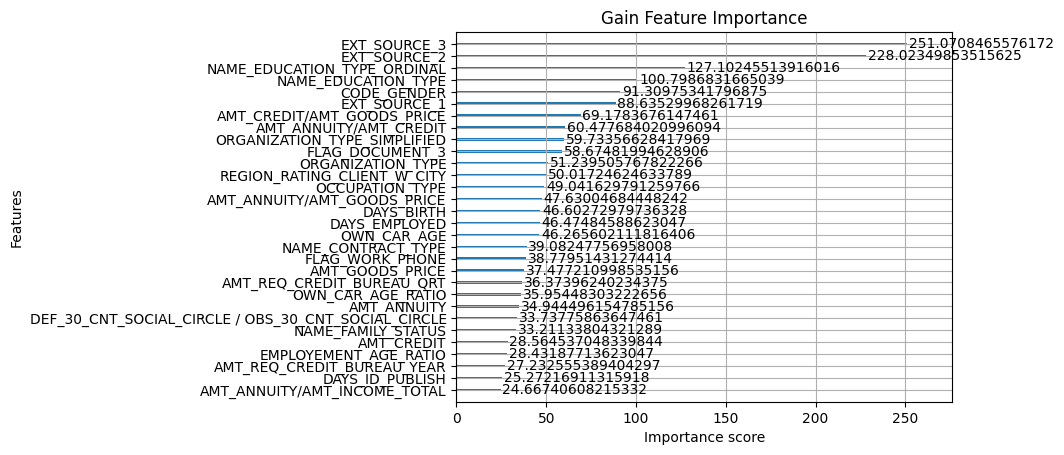

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:228: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



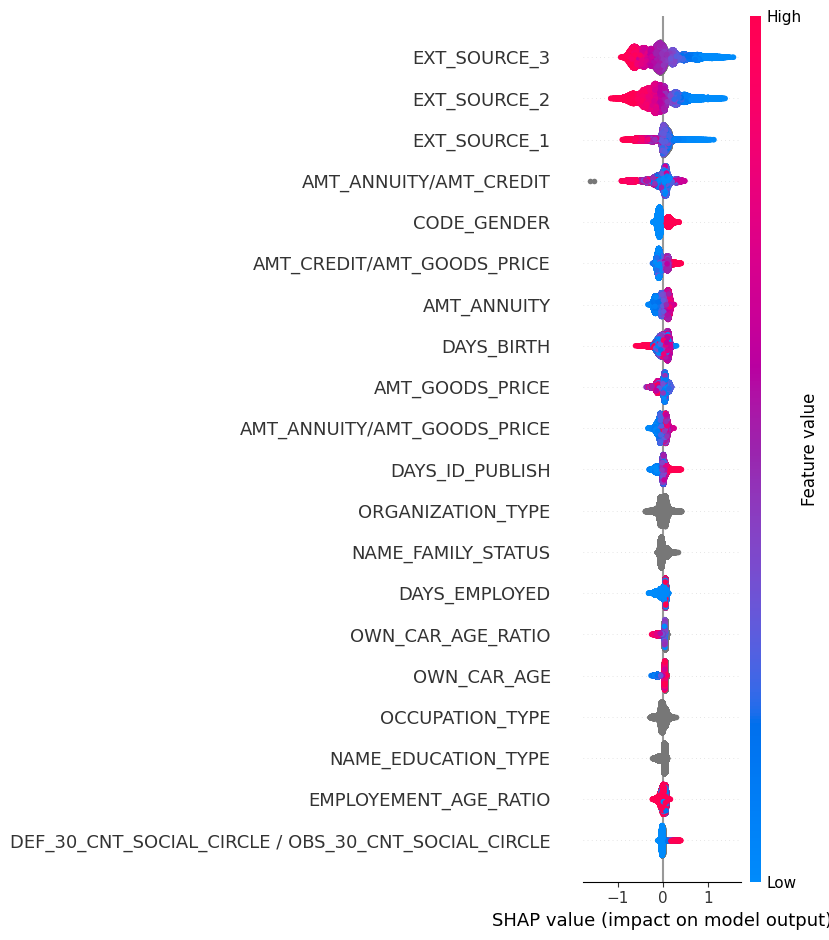

In [26]:
params = study.best_params
params.update(FIXED_PARAMS)

importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval[to_keep], 
    y_trainval=y_trainval,
    X_train=X_train[to_keep], 
    y_train=y_train,
    X_val=X_val[to_keep],
    y_val=y_val,
    X_test=X_test[to_keep], 
    submission_name="submission3", 
    seed=random_state,
    nfold=5, 
    num_boost_round=1000, 
    early_stopping_rounds=10,
    stratified=True, 
    metrics="auc",
)

In [27]:
#get_ordered_importance(importance)
shap_importance = get_ordered_shap_importance(X_val[to_keep], shap_values)
shap_importance

,Feature,shap_importance,%shap_importance,CUMSUM %shap_importance
0,EXT_SOURCE_3,0.380391,14.344507,14.344507
1,EXT_SOURCE_2,0.337202,12.715854,27.060360
2,EXT_SOURCE_1,0.165199,6.229620,33.289982
3,AMT_ANNUITY/AMT_CREDIT,0.156901,5.916731,39.206711
4,CODE_GENDER,0.108240,4.081718,43.288429
5,AMT_CREDIT/AMT_GOODS_PRICE,0.098637,3.719583,47.008011
6,AMT_ANNUITY,0.095652,3.607022,50.615032
7,DAYS_BIRTH,0.091373,3.445676,54.060707
8,AMT_GOODS_PRICE,0.082792,3.122062,57.182770
9,AMT_ANNUITY/AMT_GOODS_PRICE,0.071943,2.712953,59.895721


In [28]:
def objective(trial):

    optuna_params = {
        # Tuned parameters
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 100.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 100.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 5.0, 15.0),
    }
    optuna_params.update(FIXED_PARAMS)

    n_estimators = 500

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=trial.number) # use trial.number for different splits per trial
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_train_optuna, X_val_optuna = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_optuna, y_val_optuna = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(
            **optuna_params,
            n_estimators=n_estimators,
            random_state=random_state,
            early_stopping_rounds=None, #disable early stopping for optuna
            n_jobs=-1,
            enable_categorical=True
        )

        model.fit(
            X_train_optuna,
            y_train_optuna,
            eval_set=[(X_val_optuna, y_val_optuna)],
            verbose=False,
        )

        preds = model.predict_proba(X_val_optuna)[:, 1]
        auc = roc_auc_score(y_val_optuna, preds)
        aucs.append(auc)

    return np.mean(aucs)


study = optuna.create_study(
    study_name="optuna_study_2",
    storage="sqlite:///optuna.db",
    load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=random_state),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20),
)
#study.enqueue_trial(INITIAL_PARAMS)
study.optimize(objective, n_trials=100, timeout=None, show_progress_bar=True, n_jobs=-1)

print("Best CV AUC:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-12-29 10:41:31,078] A new study created in RDB with name: optuna_study_2
Best trial: 1. Best value: 0.764346:   1%|          | 1/100 [05:09<8:29:54, 309.04s/it]

[I 2025-12-29 10:46:40,090] Trial 1 finished with value: 0.7643456745446583 and parameters: {'max_depth': 4, 'eta': 0.048873717222019365, 'subsample': 0.976746736153618, 'colsample_bytree': 0.610795705787555, 'reg_alpha': 7.237635353971554, 'reg_lambda': 0.33747687753084865, 'min_child_weight': 8, 'scale_pos_weight': 12.98405611323469}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:   2%|▏         | 2/100 [05:20<3:39:05, 134.14s/it]

[I 2025-12-29 10:46:51,817] Trial 5 finished with value: 0.7559746058841595 and parameters: {'max_depth': 4, 'eta': 0.012821709385835116, 'subsample': 0.9596789691794434, 'colsample_bytree': 0.6230704548673439, 'reg_alpha': 0.6716686320013555, 'reg_lambda': 1.7610933383755007, 'min_child_weight': 5, 'scale_pos_weight': 7.6476123682109085}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:   3%|▎         | 3/100 [05:39<2:11:49, 81.54s/it] 

[I 2025-12-29 10:47:10,762] Trial 11 finished with value: 0.7381947376383857 and parameters: {'max_depth': 4, 'eta': 0.2555694410644766, 'subsample': 0.6825115845860563, 'colsample_bytree': 0.6398627495684385, 'reg_alpha': 0.15616210697573285, 'reg_lambda': 0.05065507483909235, 'min_child_weight': 2, 'scale_pos_weight': 8.342568264517215}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:   4%|▍         | 4/100 [06:49<2:02:55, 76.82s/it]

[I 2025-12-29 10:48:20,306] Trial 4 finished with value: 0.7596508360705935 and parameters: {'max_depth': 5, 'eta': 0.015508207208497379, 'subsample': 0.6071287750107619, 'colsample_bytree': 0.9042892820196677, 'reg_alpha': 0.4020831476432948, 'reg_lambda': 2.478455684792349, 'min_child_weight': 8, 'scale_pos_weight': 6.584725210600632}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:   5%|▌         | 5/100 [07:09<1:29:30, 56.54s/it]

[I 2025-12-29 10:48:40,901] Trial 3 finished with value: 0.7388016773427813 and parameters: {'max_depth': 5, 'eta': 0.15501178068545518, 'subsample': 0.6298395163019878, 'colsample_bytree': 0.9843223083963608, 'reg_alpha': 0.3725137084553979, 'reg_lambda': 0.23177520162874587, 'min_child_weight': 4, 'scale_pos_weight': 9.280499497245374}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:   6%|▌         | 6/100 [08:05<1:28:18, 56.37s/it]

[I 2025-12-29 10:49:36,980] Trial 9 finished with value: 0.7107622251927552 and parameters: {'max_depth': 6, 'eta': 0.2574083998869467, 'subsample': 0.842198905919795, 'colsample_bytree': 0.7556999724789242, 'reg_alpha': 0.040017048475870495, 'reg_lambda': 0.02061634556236215, 'min_child_weight': 3, 'scale_pos_weight': 12.97205437785922}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:   7%|▋         | 7/100 [08:39<1:15:37, 48.79s/it]

[I 2025-12-29 10:50:10,045] Trial 7 finished with value: 0.7507973800175343 and parameters: {'max_depth': 6, 'eta': 0.13323615952710446, 'subsample': 0.6835804912510443, 'colsample_bytree': 0.773318734589748, 'reg_alpha': 25.75788402148623, 'reg_lambda': 0.026862602417581753, 'min_child_weight': 6, 'scale_pos_weight': 6.4145112791244765}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:   8%|▊         | 8/100 [09:35<1:18:20, 51.09s/it]

[I 2025-12-29 10:51:06,049] Trial 10 finished with value: 0.7297510691923851 and parameters: {'max_depth': 7, 'eta': 0.15631961469029382, 'subsample': 0.8520040278242742, 'colsample_bytree': 0.61156158290745, 'reg_alpha': 5.334839063452562, 'reg_lambda': 0.3315014332340486, 'min_child_weight': 5, 'scale_pos_weight': 13.322575750928781}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:   9%|▉         | 9/100 [09:43<57:27, 37.88s/it]  

[I 2025-12-29 10:51:14,904] Trial 0 finished with value: 0.7526889270168582 and parameters: {'max_depth': 7, 'eta': 0.03849612297687819, 'subsample': 0.6310684751590784, 'colsample_bytree': 0.7804116985335898, 'reg_alpha': 0.026842224721783173, 'reg_lambda': 0.11616938745046483, 'min_child_weight': 7, 'scale_pos_weight': 11.78000839213711}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  10%|█         | 10/100 [09:58<46:07, 30.75s/it]

[I 2025-12-29 10:51:29,799] Trial 8 finished with value: 0.7266608464961963 and parameters: {'max_depth': 7, 'eta': 0.27502292123255195, 'subsample': 0.6336932956675891, 'colsample_bytree': 0.6770646679441675, 'reg_alpha': 33.253132473467495, 'reg_lambda': 10.522444148501815, 'min_child_weight': 2, 'scale_pos_weight': 13.325528159374521}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  11%|█         | 11/100 [10:18<40:32, 27.33s/it]

[I 2025-12-29 10:51:49,384] Trial 6 finished with value: 0.7130952663557115 and parameters: {'max_depth': 8, 'eta': 0.17918964640627905, 'subsample': 0.9055598346357764, 'colsample_bytree': 0.809628996692858, 'reg_alpha': 2.288220841732563, 'reg_lambda': 0.5641468838242055, 'min_child_weight': 3, 'scale_pos_weight': 13.305122584537244}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  12%|█▏        | 12/100 [11:06<49:13, 33.56s/it]

[I 2025-12-29 10:52:37,194] Trial 2 finished with value: 0.7521696067400446 and parameters: {'max_depth': 8, 'eta': 0.011300686227501664, 'subsample': 0.9104883424912661, 'colsample_bytree': 0.7510557764372409, 'reg_alpha': 0.03510462304515125, 'reg_lambda': 0.05108702507242288, 'min_child_weight': 1, 'scale_pos_weight': 9.665938110155512}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  13%|█▎        | 13/100 [12:01<58:03, 40.04s/it]

[I 2025-12-29 10:53:32,139] Trial 12 finished with value: 0.7589285312671239 and parameters: {'max_depth': 3, 'eta': 0.026715210933307917, 'subsample': 0.9686615941000041, 'colsample_bytree': 0.6529858735187616, 'reg_alpha': 0.015663260463903716, 'reg_lambda': 0.48613463700908205, 'min_child_weight': 4, 'scale_pos_weight': 13.922083788102341}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  14%|█▍        | 14/100 [12:25<50:37, 35.32s/it]

[I 2025-12-29 10:53:56,540] Trial 14 finished with value: 0.7641593977190496 and parameters: {'max_depth': 3, 'eta': 0.09453357110803759, 'subsample': 0.9669718489094314, 'colsample_bytree': 0.9583213284127714, 'reg_alpha': 0.02713903857306934, 'reg_lambda': 79.46713264783321, 'min_child_weight': 4, 'scale_pos_weight': 14.31690824498273}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  15%|█▌        | 15/100 [13:07<52:47, 37.26s/it]

[I 2025-12-29 10:54:38,316] Trial 16 finished with value: 0.7606637127511405 and parameters: {'max_depth': 3, 'eta': 0.03660668496219682, 'subsample': 0.9562014253277312, 'colsample_bytree': 0.634071575682407, 'reg_alpha': 0.8416481722102891, 'reg_lambda': 0.010151193776841596, 'min_child_weight': 2, 'scale_pos_weight': 9.669054332985107}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  16%|█▌        | 16/100 [13:39<50:11, 35.85s/it]

[I 2025-12-29 10:55:10,886] Trial 13 finished with value: 0.7339832614310198 and parameters: {'max_depth': 5, 'eta': 0.2718827684362994, 'subsample': 0.8936086437672915, 'colsample_bytree': 0.9504197967694263, 'reg_alpha': 4.659252104563222, 'reg_lambda': 1.2015080245368757, 'min_child_weight': 8, 'scale_pos_weight': 6.907626290900939}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  17%|█▋        | 17/100 [14:34<57:20, 41.45s/it]

[I 2025-12-29 10:56:05,316] Trial 21 finished with value: 0.7617126937181616 and parameters: {'max_depth': 3, 'eta': 0.0456392127688063, 'subsample': 0.9981110479345863, 'colsample_bytree': 0.8614962838122326, 'reg_alpha': 3.711379352813547, 'reg_lambda': 17.07430824319626, 'min_child_weight': 10, 'scale_pos_weight': 14.811367448316911}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  18%|█▊        | 18/100 [14:44<43:57, 32.16s/it]

[I 2025-12-29 10:56:15,893] Trial 15 finished with value: 0.7571509152540126 and parameters: {'max_depth': 6, 'eta': 0.055288905137731825, 'subsample': 0.9280508377681487, 'colsample_bytree': 0.7558255856219959, 'reg_alpha': 0.021618180607715694, 'reg_lambda': 1.688259437808564, 'min_child_weight': 9, 'scale_pos_weight': 12.710274647326234}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  19%|█▉        | 19/100 [14:58<35:53, 26.59s/it]

[I 2025-12-29 10:56:29,405] Trial 22 finished with value: 0.7576635481198678 and parameters: {'max_depth': 3, 'eta': 0.020566340144122, 'subsample': 0.7615871879898987, 'colsample_bytree': 0.9264952493526871, 'reg_alpha': 6.5384699223772165, 'reg_lambda': 3.349550379208948, 'min_child_weight': 10, 'scale_pos_weight': 10.501216350179229}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  20%|██        | 20/100 [15:42<42:35, 31.95s/it]

[I 2025-12-29 10:57:13,943] Trial 23 finished with value: 0.7608771506230906 and parameters: {'max_depth': 3, 'eta': 0.029507129783002854, 'subsample': 0.7581356568649449, 'colsample_bytree': 0.901662761302314, 'reg_alpha': 8.418479322482012, 'reg_lambda': 3.910304469417734, 'min_child_weight': 10, 'scale_pos_weight': 5.323882707927524}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 1. Best value: 0.764346:  21%|██        | 21/100 [16:15<42:22, 32.19s/it]

[I 2025-12-29 10:57:46,656] Trial 19 finished with value: 0.7609217467538159 and parameters: {'max_depth': 6, 'eta': 0.05287737062342084, 'subsample': 0.9422915796087229, 'colsample_bytree': 0.9927676899298624, 'reg_alpha': 0.25072036078700816, 'reg_lambda': 66.56684699208294, 'min_child_weight': 5, 'scale_pos_weight': 10.548567329582795}. Best is trial 1 with value: 0.7643456745446583.


Best trial: 18. Best value: 0.76552:  22%|██▏       | 22/100 [16:23<32:23, 24.92s/it]

[I 2025-12-29 10:57:54,644] Trial 18 finished with value: 0.7655203146425291 and parameters: {'max_depth': 7, 'eta': 0.043166705352752036, 'subsample': 0.62417197779283, 'colsample_bytree': 0.6189098096448409, 'reg_alpha': 57.777363717958096, 'reg_lambda': 0.3040035094946739, 'min_child_weight': 1, 'scale_pos_weight': 8.17890704654689}. Best is trial 18 with value: 0.7655203146425291.


Best trial: 18. Best value: 0.76552:  23%|██▎       | 23/100 [16:26<23:33, 18.35s/it]

[I 2025-12-29 10:57:57,700] Trial 17 finished with value: 0.7581051630610715 and parameters: {'max_depth': 7, 'eta': 0.016767877295550553, 'subsample': 0.8329050962149666, 'colsample_bytree': 0.6286314646074372, 'reg_alpha': 0.363372080031501, 'reg_lambda': 0.35407821347972623, 'min_child_weight': 3, 'scale_pos_weight': 9.780438153700171}. Best is trial 18 with value: 0.7655203146425291.


Best trial: 18. Best value: 0.76552:  24%|██▍       | 24/100 [16:58<28:14, 22.29s/it]

[I 2025-12-29 10:58:29,145] Trial 25 finished with value: 0.7640118713045971 and parameters: {'max_depth': 3, 'eta': 0.072551228344287, 'subsample': 0.9985444218275616, 'colsample_bytree': 0.8855899686034745, 'reg_alpha': 4.115686225732607, 'reg_lambda': 92.13207750548965, 'min_child_weight': 10, 'scale_pos_weight': 11.881432878668909}. Best is trial 18 with value: 0.7655203146425291.


Best trial: 18. Best value: 0.76552:  25%|██▌       | 25/100 [17:20<27:51, 22.29s/it]

[I 2025-12-29 10:58:51,470] Trial 24 finished with value: 0.7649008864195478 and parameters: {'max_depth': 4, 'eta': 0.0624423119023793, 'subsample': 0.7638923739115315, 'colsample_bytree': 0.9164277803105271, 'reg_alpha': 4.444633885684114, 'reg_lambda': 4.742587750139084, 'min_child_weight': 10, 'scale_pos_weight': 5.591249181995193}. Best is trial 18 with value: 0.7655203146425291.


Best trial: 18. Best value: 0.76552:  26%|██▌       | 26/100 [17:54<31:41, 25.70s/it]

[I 2025-12-29 10:59:25,125] Trial 20 finished with value: 0.7278843385679561 and parameters: {'max_depth': 8, 'eta': 0.09066755826148695, 'subsample': 0.8329845671751055, 'colsample_bytree': 0.9090638275991793, 'reg_alpha': 0.08377115314994762, 'reg_lambda': 0.8160296514650255, 'min_child_weight': 4, 'scale_pos_weight': 12.524595238087961}. Best is trial 18 with value: 0.7655203146425291.


Best trial: 18. Best value: 0.76552:  27%|██▋       | 27/100 [18:30<35:17, 29.01s/it]

[I 2025-12-29 11:00:01,800] Trial 26 finished with value: 0.7633373555729627 and parameters: {'max_depth': 4, 'eta': 0.08214459631420785, 'subsample': 0.7646223531986129, 'colsample_bytree': 0.8736960085033505, 'reg_alpha': 8.443802937776509, 'reg_lambda': 90.10520291400105, 'min_child_weight': 10, 'scale_pos_weight': 14.980629236217071}. Best is trial 18 with value: 0.7655203146425291.


Best trial: 18. Best value: 0.76552:  28%|██▊       | 28/100 [19:03<36:19, 30.27s/it]

[I 2025-12-29 11:00:34,966] Trial 27 finished with value: 0.7635615803007031 and parameters: {'max_depth': 4, 'eta': 0.07967905526792461, 'subsample': 0.780849816055047, 'colsample_bytree': 0.883282931998999, 'reg_alpha': 13.054782249431923, 'reg_lambda': 76.95567460059351, 'min_child_weight': 10, 'scale_pos_weight': 14.90654018815258}. Best is trial 18 with value: 0.7655203146425291.


Best trial: 29. Best value: 0.766516:  29%|██▉       | 29/100 [19:48<40:58, 34.62s/it]

[I 2025-12-29 11:01:19,828] Trial 29 finished with value: 0.7665159957903649 and parameters: {'max_depth': 4, 'eta': 0.07981242763935666, 'subsample': 0.7713277583020385, 'colsample_bytree': 0.8680516843191948, 'reg_alpha': 80.64459547713541, 'reg_lambda': 55.9939065186888, 'min_child_weight': 7, 'scale_pos_weight': 11.294658046863717}. Best is trial 29 with value: 0.7665159957903649.


Best trial: 29. Best value: 0.766516:  30%|███       | 30/100 [19:52<29:31, 25.31s/it]

[I 2025-12-29 11:01:23,415] Trial 28 finished with value: 0.7633465933204021 and parameters: {'max_depth': 4, 'eta': 0.07894566631628144, 'subsample': 0.8211014149918509, 'colsample_bytree': 0.7047040864497904, 'reg_alpha': 0.0986821752343701, 'reg_lambda': 49.30184603166964, 'min_child_weight': 10, 'scale_pos_weight': 11.513131809745992}. Best is trial 29 with value: 0.7665159957903649.


Best trial: 29. Best value: 0.766516:  31%|███       | 31/100 [20:14<28:06, 24.44s/it]

[I 2025-12-29 11:01:45,706] Trial 30 finished with value: 0.7627528119307931 and parameters: {'max_depth': 4, 'eta': 0.0828559253877042, 'subsample': 0.8472264800185481, 'colsample_bytree': 0.700493684676395, 'reg_alpha': 0.12564746257447457, 'reg_lambda': 70.14829383787013, 'min_child_weight': 7, 'scale_pos_weight': 11.524230971565892}. Best is trial 29 with value: 0.7665159957903649.


Best trial: 29. Best value: 0.766516:  32%|███▏      | 32/100 [20:43<29:14, 25.81s/it]

[I 2025-12-29 11:02:14,816] Trial 31 finished with value: 0.7637872521519304 and parameters: {'max_depth': 4, 'eta': 0.07720890305526146, 'subsample': 0.9964149338538775, 'colsample_bytree': 0.6994917579259948, 'reg_alpha': 0.11951489635092087, 'reg_lambda': 47.53199496249936, 'min_child_weight': 7, 'scale_pos_weight': 11.5382952668816}. Best is trial 29 with value: 0.7665159957903649.


Best trial: 29. Best value: 0.766516:  33%|███▎      | 33/100 [21:23<33:21, 29.88s/it]

[I 2025-12-29 11:02:54,190] Trial 32 finished with value: 0.7648223196483604 and parameters: {'max_depth': 4, 'eta': 0.08463259047370972, 'subsample': 0.9816018640357316, 'colsample_bytree': 0.8541963211299858, 'reg_alpha': 16.07453976654212, 'reg_lambda': 44.726365629976044, 'min_child_weight': 9, 'scale_pos_weight': 14.772674768739892}. Best is trial 29 with value: 0.7665159957903649.


Best trial: 34. Best value: 0.767722:  34%|███▍      | 34/100 [21:23<23:08, 21.04s/it]

[I 2025-12-29 11:02:54,498] Trial 34 finished with value: 0.7677223135910118 and parameters: {'max_depth': 4, 'eta': 0.07197027372590119, 'subsample': 0.9905607393168464, 'colsample_bytree': 0.6967336786649776, 'reg_alpha': 97.4619050648023, 'reg_lambda': 69.97630513819816, 'min_child_weight': 1, 'scale_pos_weight': 14.874699757733472}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  35%|███▌      | 35/100 [21:29<17:49, 16.45s/it]

[I 2025-12-29 11:03:00,349] Trial 33 finished with value: 0.7669047807213799 and parameters: {'max_depth': 4, 'eta': 0.08619827972233264, 'subsample': 0.8595447383412442, 'colsample_bytree': 0.6803902513474743, 'reg_alpha': 72.58189180938874, 'reg_lambda': 0.13366461821312117, 'min_child_weight': 7, 'scale_pos_weight': 14.97178814097018}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  36%|███▌      | 36/100 [22:07<24:27, 22.93s/it]

[I 2025-12-29 11:03:38,407] Trial 35 finished with value: 0.7667996039001311 and parameters: {'max_depth': 4, 'eta': 0.08648652938257263, 'subsample': 0.7895025342808549, 'colsample_bytree': 0.6948075221583762, 'reg_alpha': 67.25751420354253, 'reg_lambda': 10.841777466293431, 'min_child_weight': 1, 'scale_pos_weight': 14.890768615701099}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  37%|███▋      | 37/100 [22:22<21:38, 20.61s/it]

[I 2025-12-29 11:03:53,584] Trial 36 finished with value: 0.7671668901249171 and parameters: {'max_depth': 4, 'eta': 0.07622153483598319, 'subsample': 0.7551743478039006, 'colsample_bytree': 0.7096494828010749, 'reg_alpha': 88.94300231615664, 'reg_lambda': 0.13659764716491496, 'min_child_weight': 7, 'scale_pos_weight': 5.373698018119008}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  38%|███▊      | 38/100 [23:03<27:33, 26.67s/it]

[I 2025-12-29 11:04:34,350] Trial 37 finished with value: 0.7656072365132938 and parameters: {'max_depth': 4, 'eta': 0.061273986086818444, 'subsample': 0.749318675103858, 'colsample_bytree': 0.6932609902871558, 'reg_alpha': 14.418644378331699, 'reg_lambda': 0.14570817526431212, 'min_child_weight': 8, 'scale_pos_weight': 5.358487225118169}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  39%|███▉      | 39/100 [23:31<27:32, 27.09s/it]

[I 2025-12-29 11:05:02,456] Trial 38 finished with value: 0.7670595548595467 and parameters: {'max_depth': 4, 'eta': 0.06418461421082924, 'subsample': 0.7118271692355526, 'colsample_bytree': 0.6997487605468247, 'reg_alpha': 67.29342225571732, 'reg_lambda': 0.1414932598077077, 'min_child_weight': 8, 'scale_pos_weight': 5.368400167782154}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  40%|████      | 40/100 [24:44<40:53, 40.89s/it]

[I 2025-12-29 11:06:15,497] Trial 39 finished with value: 0.7666879263367573 and parameters: {'max_depth': 5, 'eta': 0.05714930068609238, 'subsample': 0.7190081680869918, 'colsample_bytree': 0.7007562783414907, 'reg_alpha': 98.94214954143035, 'reg_lambda': 0.1255135649359733, 'min_child_weight': 8, 'scale_pos_weight': 8.585759873165852}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  41%|████      | 41/100 [25:28<41:08, 41.84s/it]

[I 2025-12-29 11:06:59,564] Trial 40 finished with value: 0.7646748992720112 and parameters: {'max_depth': 5, 'eta': 0.11660575380505116, 'subsample': 0.7241818105370642, 'colsample_bytree': 0.7117018431968754, 'reg_alpha': 79.1034434551077, 'reg_lambda': 28.507463030972502, 'min_child_weight': 7, 'scale_pos_weight': 5.007590254286713}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  42%|████▏     | 42/100 [25:36<30:37, 31.69s/it]

[I 2025-12-29 11:07:07,545] Trial 41 finished with value: 0.7644307154576081 and parameters: {'max_depth': 5, 'eta': 0.11255861088317183, 'subsample': 0.705849377062581, 'colsample_bytree': 0.8436845560926401, 'reg_alpha': 68.7049974570446, 'reg_lambda': 7.87131224830196, 'min_child_weight': 7, 'scale_pos_weight': 5.285848148720293}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  43%|████▎     | 43/100 [25:57<27:10, 28.60s/it]

[I 2025-12-29 11:07:28,934] Trial 42 finished with value: 0.7666484543445663 and parameters: {'max_depth': 5, 'eta': 0.03827404696215122, 'subsample': 0.7075814746013492, 'colsample_bytree': 0.8110176686386085, 'reg_alpha': 84.5775550931724, 'reg_lambda': 0.1573596334561429, 'min_child_weight': 7, 'scale_pos_weight': 8.770197546496123}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  44%|████▍     | 44/100 [26:21<25:24, 27.23s/it]

[I 2025-12-29 11:07:52,980] Trial 43 finished with value: 0.766580498364011 and parameters: {'max_depth': 5, 'eta': 0.06100338997654323, 'subsample': 0.6940353246509422, 'colsample_bytree': 0.8464157071639663, 'reg_alpha': 86.40105310219543, 'reg_lambda': 0.11952145390165755, 'min_child_weight': 8, 'scale_pos_weight': 5.115218009259649}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  45%|████▌     | 45/100 [26:58<27:37, 30.13s/it]

[I 2025-12-29 11:08:29,888] Trial 45 finished with value: 0.7667749319414018 and parameters: {'max_depth': 5, 'eta': 0.059554155660373566, 'subsample': 0.7214803850813499, 'colsample_bytree': 0.824744749603659, 'reg_alpha': 76.63604339546514, 'reg_lambda': 11.860990817866215, 'min_child_weight': 1, 'scale_pos_weight': 5.151985051590806}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  46%|████▌     | 46/100 [27:08<21:42, 24.11s/it]

[I 2025-12-29 11:08:39,954] Trial 44 finished with value: 0.7633812404180043 and parameters: {'max_depth': 5, 'eta': 0.11353817909601956, 'subsample': 0.727792885072684, 'colsample_bytree': 0.8375131229549713, 'reg_alpha': 89.28314384275689, 'reg_lambda': 22.800078553421056, 'min_child_weight': 9, 'scale_pos_weight': 8.87499239049331}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  47%|████▋     | 47/100 [27:11<15:39, 17.73s/it]

[I 2025-12-29 11:08:42,855] Trial 46 finished with value: 0.7644837885426151 and parameters: {'max_depth': 5, 'eta': 0.11275865975521308, 'subsample': 0.7062598986198472, 'colsample_bytree': 0.6644701691939551, 'reg_alpha': 82.22149209234806, 'reg_lambda': 0.1419047826715473, 'min_child_weight': 1, 'scale_pos_weight': 8.579952859617709}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  48%|████▊     | 48/100 [27:52<21:25, 24.72s/it]

[I 2025-12-29 11:09:23,882] Trial 47 finished with value: 0.7629429597193091 and parameters: {'max_depth': 5, 'eta': 0.11360684511266901, 'subsample': 0.7226406083213875, 'colsample_bytree': 0.8268868392226045, 'reg_alpha': 82.01246341701393, 'reg_lambda': 21.135645630005598, 'min_child_weight': 6, 'scale_pos_weight': 14.03206833063475}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  49%|████▉     | 49/100 [28:09<18:56, 22.29s/it]

[I 2025-12-29 11:09:40,500] Trial 48 finished with value: 0.7611502907875064 and parameters: {'max_depth': 5, 'eta': 0.11324284029637521, 'subsample': 0.727599743330579, 'colsample_bytree': 0.7202641323745566, 'reg_alpha': 43.66029180465262, 'reg_lambda': 0.15310969876328184, 'min_child_weight': 6, 'scale_pos_weight': 14.056536440088905}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  50%|█████     | 50/100 [28:43<21:24, 25.70s/it]

[I 2025-12-29 11:10:14,138] Trial 49 finished with value: 0.7635023408688808 and parameters: {'max_depth': 5, 'eta': 0.1104792249348872, 'subsample': 0.7245421130225408, 'colsample_bytree': 0.7210157216430458, 'reg_alpha': 88.82379690337173, 'reg_lambda': 20.000550840754432, 'min_child_weight': 6, 'scale_pos_weight': 14.014614947591221}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  51%|█████     | 51/100 [29:16<22:56, 28.09s/it]

[I 2025-12-29 11:10:47,658] Trial 50 finished with value: 0.762000093188183 and parameters: {'max_depth': 5, 'eta': 0.11528071316007638, 'subsample': 0.7281191347943654, 'colsample_bytree': 0.7298401412638384, 'reg_alpha': 39.60445347198039, 'reg_lambda': 0.09282302650391806, 'min_child_weight': 6, 'scale_pos_weight': 6.184068210945227}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  52%|█████▏    | 52/100 [30:33<34:11, 42.73s/it]

[I 2025-12-29 11:12:04,612] Trial 51 finished with value: 0.7624809486768138 and parameters: {'max_depth': 5, 'eta': 0.11660000220488045, 'subsample': 0.7232883240297867, 'colsample_bytree': 0.7297887633293098, 'reg_alpha': 39.770719188364666, 'reg_lambda': 0.06937661970335882, 'min_child_weight': 6, 'scale_pos_weight': 6.3697621776898625}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  53%|█████▎    | 53/100 [31:11<32:23, 41.36s/it]

[I 2025-12-29 11:12:42,834] Trial 52 finished with value: 0.7611674969187605 and parameters: {'max_depth': 5, 'eta': 0.11271828322351109, 'subsample': 0.8015620346976255, 'colsample_bytree': 0.7309184705008607, 'reg_alpha': 41.95047013635931, 'reg_lambda': 0.06895337229011132, 'min_child_weight': 6, 'scale_pos_weight': 14.009447066651058}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  54%|█████▍    | 54/100 [31:19<23:59, 31.29s/it]

[I 2025-12-29 11:12:50,494] Trial 53 finished with value: 0.7613965406293798 and parameters: {'max_depth': 5, 'eta': 0.10814082924960522, 'subsample': 0.7967986196978173, 'colsample_bytree': 0.6694734874195486, 'reg_alpha': 42.17492907581685, 'reg_lambda': 0.06808977940791226, 'min_child_weight': 6, 'scale_pos_weight': 14.063909497140397}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  55%|█████▌    | 55/100 [31:23<17:22, 23.17s/it]

[I 2025-12-29 11:12:54,903] Trial 55 finished with value: 0.7650826687925582 and parameters: {'max_depth': 4, 'eta': 0.10501196839273623, 'subsample': 0.8739992703655486, 'colsample_bytree': 0.7365350457815623, 'reg_alpha': 35.767628787814715, 'reg_lambda': 0.06211330303031662, 'min_child_weight': 6, 'scale_pos_weight': 14.012964120146233}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  56%|█████▌    | 56/100 [31:37<14:48, 20.19s/it]

[I 2025-12-29 11:13:08,131] Trial 54 finished with value: 0.7645703635659542 and parameters: {'max_depth': 5, 'eta': 0.10634294160243116, 'subsample': 0.8743619159140958, 'colsample_bytree': 0.7327495653338746, 'reg_alpha': 41.14754872197116, 'reg_lambda': 0.055825393638221005, 'min_child_weight': 6, 'scale_pos_weight': 6.022177693027706}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  57%|█████▋    | 57/100 [32:01<15:23, 21.47s/it]

[I 2025-12-29 11:13:32,542] Trial 56 finished with value: 0.7661644130948677 and parameters: {'max_depth': 4, 'eta': 0.10531251369511348, 'subsample': 0.8053311917395587, 'colsample_bytree': 0.7361490064583364, 'reg_alpha': 36.97517197525527, 'reg_lambda': 0.07033453010868011, 'min_child_weight': 6, 'scale_pos_weight': 6.070951327677819}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  58%|█████▊    | 58/100 [32:17<13:54, 19.86s/it]

[I 2025-12-29 11:13:48,637] Trial 57 finished with value: 0.7646421149135328 and parameters: {'max_depth': 4, 'eta': 0.1015452292326049, 'subsample': 0.7998472417133488, 'colsample_bytree': 0.7268073808560984, 'reg_alpha': 36.2088357318746, 'reg_lambda': 0.05057740672879219, 'min_child_weight': 6, 'scale_pos_weight': 13.879980595643747}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  59%|█████▉    | 59/100 [32:23<10:37, 15.55s/it]

[I 2025-12-29 11:13:54,178] Trial 58 finished with value: 0.7595286588276144 and parameters: {'max_depth': 4, 'eta': 0.1859173102770174, 'subsample': 0.7984506620407026, 'colsample_bytree': 0.7216906659948572, 'reg_alpha': 41.70880117992041, 'reg_lambda': 0.05459476981860655, 'min_child_weight': 6, 'scale_pos_weight': 13.932868083066035}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  60%|██████    | 60/100 [33:02<15:02, 22.57s/it]

[I 2025-12-29 11:14:33,108] Trial 59 finished with value: 0.761759146420515 and parameters: {'max_depth': 4, 'eta': 0.17645746344189833, 'subsample': 0.8016994205098922, 'colsample_bytree': 0.7252808988369448, 'reg_alpha': 42.433253016558645, 'reg_lambda': 0.0677107075486426, 'min_child_weight': 6, 'scale_pos_weight': 6.022429726353363}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  61%|██████    | 61/100 [33:12<12:18, 18.95s/it]

[I 2025-12-29 11:14:43,606] Trial 60 finished with value: 0.7625139602467551 and parameters: {'max_depth': 4, 'eta': 0.16857357348423455, 'subsample': 0.8850454420582771, 'colsample_bytree': 0.7387007269844652, 'reg_alpha': 28.27268391013875, 'reg_lambda': 0.05039480580853557, 'min_child_weight': 2, 'scale_pos_weight': 5.977005825681161}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  62%|██████▏   | 62/100 [33:49<15:21, 24.24s/it]

[I 2025-12-29 11:15:20,194] Trial 61 finished with value: 0.7612754416515359 and parameters: {'max_depth': 4, 'eta': 0.18230851849318933, 'subsample': 0.8841277752643023, 'colsample_bytree': 0.7369679759890829, 'reg_alpha': 25.719476678007535, 'reg_lambda': 0.0582373577663442, 'min_child_weight': 2, 'scale_pos_weight': 5.826953388679632}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  63%|██████▎   | 63/100 [34:26<17:18, 28.07s/it]

[I 2025-12-29 11:15:57,218] Trial 62 finished with value: 0.7660879731172464 and parameters: {'max_depth': 4, 'eta': 0.06701353300817166, 'subsample': 0.6582053571966625, 'colsample_bytree': 0.773861065364675, 'reg_alpha': 27.39846196715548, 'reg_lambda': 0.06469518141542746, 'min_child_weight': 1, 'scale_pos_weight': 7.134209621578165}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  64%|██████▍   | 64/100 [35:43<25:39, 42.76s/it]

[I 2025-12-29 11:17:14,226] Trial 63 finished with value: 0.7628117680565926 and parameters: {'max_depth': 4, 'eta': 0.1524410098276339, 'subsample': 0.8759653288404621, 'colsample_bytree': 0.7784949193165456, 'reg_alpha': 25.596289774550215, 'reg_lambda': 11.966155702250964, 'min_child_weight': 1, 'scale_pos_weight': 7.609580552151523}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  65%|██████▌   | 65/100 [36:34<26:28, 45.40s/it]

[I 2025-12-29 11:18:05,749] Trial 64 finished with value: 0.7582751026130723 and parameters: {'max_depth': 4, 'eta': 0.14796737209536237, 'subsample': 0.6598304288203669, 'colsample_bytree': 0.7811440113059952, 'reg_alpha': 26.439034737058112, 'reg_lambda': 0.031025393946835483, 'min_child_weight': 1, 'scale_pos_weight': 14.412058004056917}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  66%|██████▌   | 66/100 [36:35<18:06, 31.97s/it]

[I 2025-12-29 11:18:06,449] Trial 65 finished with value: 0.7660747677213319 and parameters: {'max_depth': 4, 'eta': 0.06798367182673762, 'subsample': 0.6592813870396155, 'colsample_bytree': 0.6801945613023158, 'reg_alpha': 27.59774111521919, 'reg_lambda': 0.029873688796519263, 'min_child_weight': 1, 'scale_pos_weight': 7.2983616340195745}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  67%|██████▋   | 67/100 [36:39<12:55, 23.49s/it]

[I 2025-12-29 11:18:10,148] Trial 68 finished with value: 0.7659680570737979 and parameters: {'max_depth': 3, 'eta': 0.067772013138283, 'subsample': 0.6505557053990013, 'colsample_bytree': 0.7798683404281519, 'reg_alpha': 22.408425278395434, 'reg_lambda': 0.03773901024669475, 'min_child_weight': 2, 'scale_pos_weight': 7.015963297506117}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  68%|██████▊   | 68/100 [36:39<08:48, 16.53s/it]

[I 2025-12-29 11:18:10,430] Trial 66 finished with value: 0.7649645150915696 and parameters: {'max_depth': 4, 'eta': 0.07162704009712138, 'subsample': 0.6722018282241911, 'colsample_bytree': 0.7662253034347695, 'reg_alpha': 19.359591603062654, 'reg_lambda': 0.02938604827677061, 'min_child_weight': 1, 'scale_pos_weight': 7.067431342424243}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  69%|██████▉   | 69/100 [36:47<07:09, 13.86s/it]

[I 2025-12-29 11:18:18,061] Trial 67 finished with value: 0.7663392614357203 and parameters: {'max_depth': 4, 'eta': 0.06804971683854057, 'subsample': 0.6550620282152018, 'colsample_bytree': 0.7777436679762364, 'reg_alpha': 56.15366987802672, 'reg_lambda': 11.475730397983252, 'min_child_weight': 2, 'scale_pos_weight': 7.368682066809156}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  70%|███████   | 70/100 [36:52<05:40, 11.36s/it]

[I 2025-12-29 11:18:23,595] Trial 69 finished with value: 0.7662120321078698 and parameters: {'max_depth': 3, 'eta': 0.06888662670959562, 'subsample': 0.7495836228839728, 'colsample_bytree': 0.7644153545541527, 'reg_alpha': 26.818335318038404, 'reg_lambda': 9.59136839020671, 'min_child_weight': 2, 'scale_pos_weight': 7.706349520381557}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  71%|███████   | 71/100 [37:00<04:57, 10.25s/it]

[I 2025-12-29 11:18:31,252] Trial 70 finished with value: 0.7655236420774008 and parameters: {'max_depth': 3, 'eta': 0.07102172627427708, 'subsample': 0.7474622439317445, 'colsample_bytree': 0.7767638268504832, 'reg_alpha': 21.43276587934387, 'reg_lambda': 9.599821184266089, 'min_child_weight': 2, 'scale_pos_weight': 6.925194465734657}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  72%|███████▏  | 72/100 [37:39<08:55, 19.11s/it]

[I 2025-12-29 11:19:10,985] Trial 71 finished with value: 0.7652365426131565 and parameters: {'max_depth': 3, 'eta': 0.06962976414257231, 'subsample': 0.658860537574519, 'colsample_bytree': 0.7815441584653899, 'reg_alpha': 20.490832183723995, 'reg_lambda': 11.797885684105466, 'min_child_weight': 2, 'scale_pos_weight': 7.175624500745874}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  73%|███████▎  | 73/100 [39:37<21:52, 48.60s/it]

[I 2025-12-29 11:21:08,448] Trial 72 finished with value: 0.7663875889614613 and parameters: {'max_depth': 6, 'eta': 0.04816690875882725, 'subsample': 0.6691662606004476, 'colsample_bytree': 0.6828294035791127, 'reg_alpha': 58.51319601804944, 'reg_lambda': 0.2292137509547245, 'min_child_weight': 1, 'scale_pos_weight': 7.486299483483098}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  74%|███████▍  | 74/100 [40:26<21:10, 48.86s/it]

[I 2025-12-29 11:21:57,842] Trial 73 finished with value: 0.7613363628367711 and parameters: {'max_depth': 6, 'eta': 0.06937638152397899, 'subsample': 0.6605663269473504, 'colsample_bytree': 0.6841321091757336, 'reg_alpha': 21.978495099252637, 'reg_lambda': 0.2600001407554889, 'min_child_weight': 1, 'scale_pos_weight': 6.990833459352885}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  75%|███████▌  | 75/100 [41:05<19:02, 45.72s/it]

[I 2025-12-29 11:22:36,295] Trial 78 finished with value: 0.7647078375911034 and parameters: {'max_depth': 3, 'eta': 0.05066651468346472, 'subsample': 0.748689140990262, 'colsample_bytree': 0.6500872342058112, 'reg_alpha': 61.57831967254651, 'reg_lambda': 0.8334323798559884, 'min_child_weight': 8, 'scale_pos_weight': 14.484920363662763}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  76%|███████▌  | 76/100 [41:11<13:33, 33.90s/it]

[I 2025-12-29 11:22:42,586] Trial 74 finished with value: 0.7561424541802221 and parameters: {'max_depth': 6, 'eta': 0.04477506787188518, 'subsample': 0.6559554253682849, 'colsample_bytree': 0.7902964842650039, 'reg_alpha': 1.507578166022476, 'reg_lambda': 0.2621812601963821, 'min_child_weight': 1, 'scale_pos_weight': 7.609721960392822}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  77%|███████▋  | 77/100 [42:06<15:21, 40.08s/it]

[I 2025-12-29 11:23:37,028] Trial 75 finished with value: 0.7660151325992539 and parameters: {'max_depth': 6, 'eta': 0.05333046819340658, 'subsample': 0.6599032909039607, 'colsample_bytree': 0.6843901984203304, 'reg_alpha': 58.219923674839194, 'reg_lambda': 0.21796940013136887, 'min_child_weight': 8, 'scale_pos_weight': 6.675667305381151}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  78%|███████▊  | 78/100 [42:48<14:59, 40.88s/it]

[I 2025-12-29 11:24:19,885] Trial 76 finished with value: 0.7665337876303272 and parameters: {'max_depth': 6, 'eta': 0.04966072180543827, 'subsample': 0.7445806568209924, 'colsample_bytree': 0.6867304382037329, 'reg_alpha': 57.276937685534065, 'reg_lambda': 0.22894998926273752, 'min_child_weight': 8, 'scale_pos_weight': 6.679861934222973}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  79%|███████▉  | 79/100 [42:52<10:24, 29.72s/it]

[I 2025-12-29 11:24:23,562] Trial 77 finished with value: 0.7649893908890573 and parameters: {'max_depth': 6, 'eta': 0.05176309751909791, 'subsample': 0.738909880273931, 'colsample_bytree': 0.6431119647941752, 'reg_alpha': 59.35819167640776, 'reg_lambda': 0.2121818017155369, 'min_child_weight': 8, 'scale_pos_weight': 13.380652566969317}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  80%|████████  | 80/100 [42:52<06:58, 20.93s/it]

[I 2025-12-29 11:24:23,861] Trial 79 finished with value: 0.7666697367859993 and parameters: {'max_depth': 6, 'eta': 0.05158514331070171, 'subsample': 0.7445008156381782, 'colsample_bytree': 0.6465874092423801, 'reg_alpha': 58.5290532140732, 'reg_lambda': 0.6269027269740216, 'min_child_weight': 8, 'scale_pos_weight': 6.549525090589075}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  81%|████████  | 81/100 [43:06<05:54, 18.66s/it]

[I 2025-12-29 11:24:37,353] Trial 80 finished with value: 0.7648855042267374 and parameters: {'max_depth': 6, 'eta': 0.05246790305393935, 'subsample': 0.7497504885765128, 'colsample_bytree': 0.6487052006705853, 'reg_alpha': 57.228370149395644, 'reg_lambda': 0.2363014050451535, 'min_child_weight': 8, 'scale_pos_weight': 14.488228077402786}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  82%|████████▏ | 82/100 [43:11<04:25, 14.74s/it]

[I 2025-12-29 11:24:42,923] Trial 81 finished with value: 0.766006618914736 and parameters: {'max_depth': 6, 'eta': 0.05001450529656291, 'subsample': 0.7405001239762865, 'colsample_bytree': 0.6454478035650468, 'reg_alpha': 59.47495744179638, 'reg_lambda': 0.22302309664806622, 'min_child_weight': 8, 'scale_pos_weight': 13.447591766017766}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  83%|████████▎ | 83/100 [43:19<03:36, 12.73s/it]

[I 2025-12-29 11:24:50,981] Trial 82 finished with value: 0.7615211434981444 and parameters: {'max_depth': 6, 'eta': 0.04017537858866371, 'subsample': 0.9234463573216259, 'colsample_bytree': 0.8043221702843121, 'reg_alpha': 1.5975310965624088, 'reg_lambda': 0.21620702482128923, 'min_child_weight': 8, 'scale_pos_weight': 9.056975437142706}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  84%|████████▍ | 84/100 [43:53<05:03, 18.98s/it]

[I 2025-12-29 11:25:24,514] Trial 83 finished with value: 0.7663961211380177 and parameters: {'max_depth': 6, 'eta': 0.03926292316506025, 'subsample': 0.9155470402275893, 'colsample_bytree': 0.647742770917202, 'reg_alpha': 53.01068280710103, 'reg_lambda': 0.2404666222218142, 'min_child_weight': 8, 'scale_pos_weight': 14.447698058624141}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  85%|████████▌ | 85/100 [45:53<12:19, 49.28s/it]

[I 2025-12-29 11:27:24,526] Trial 84 finished with value: 0.7669462572568897 and parameters: {'max_depth': 6, 'eta': 0.0370948732772992, 'subsample': 0.7795511900379847, 'colsample_bytree': 0.812752682751517, 'reg_alpha': 57.57969920643437, 'reg_lambda': 0.20030009473832372, 'min_child_weight': 8, 'scale_pos_weight': 9.365924609541501}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  86%|████████▌ | 86/100 [46:41<11:22, 48.76s/it]

[I 2025-12-29 11:28:12,060] Trial 87 finished with value: 0.7666239015328975 and parameters: {'max_depth': 5, 'eta': 0.039772616301761, 'subsample': 0.7808912542617179, 'colsample_bytree': 0.805574933304929, 'reg_alpha': 99.32506077857114, 'reg_lambda': 0.541772416025452, 'min_child_weight': 9, 'scale_pos_weight': 10.292298047499138}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  87%|████████▋ | 87/100 [46:44<07:35, 35.06s/it]

[I 2025-12-29 11:28:15,116] Trial 85 finished with value: 0.7672278061030469 and parameters: {'max_depth': 6, 'eta': 0.04045038518259166, 'subsample': 0.7031103954070598, 'colsample_bytree': 0.8176093557790467, 'reg_alpha': 57.99442186258562, 'reg_lambda': 0.5711275588491185, 'min_child_weight': 8, 'scale_pos_weight': 9.097704153664267}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  88%|████████▊ | 88/100 [47:15<06:45, 33.82s/it]

[I 2025-12-29 11:28:46,095] Trial 86 finished with value: 0.7669859095274058 and parameters: {'max_depth': 6, 'eta': 0.03865475785056719, 'subsample': 0.9197061443129573, 'colsample_bytree': 0.803872405354218, 'reg_alpha': 60.17991143513851, 'reg_lambda': 0.4399321625416805, 'min_child_weight': 8, 'scale_pos_weight': 10.246102604904785}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  89%|████████▉ | 89/100 [47:39<05:40, 30.96s/it]

[I 2025-12-29 11:29:10,339] Trial 88 finished with value: 0.7672719889452264 and parameters: {'max_depth': 5, 'eta': 0.03891282102473923, 'subsample': 0.7822893910654498, 'colsample_bytree': 0.8091765494424461, 'reg_alpha': 94.61533970875084, 'reg_lambda': 0.46021578943572156, 'min_child_weight': 9, 'scale_pos_weight': 10.291701630905276}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  90%|█████████ | 90/100 [48:18<05:35, 33.56s/it]

[I 2025-12-29 11:29:49,970] Trial 89 finished with value: 0.7663626528515951 and parameters: {'max_depth': 5, 'eta': 0.03999054763424174, 'subsample': 0.7033807110606701, 'colsample_bytree': 0.8168610710555337, 'reg_alpha': 68.72857547755734, 'reg_lambda': 1.8664234046208088, 'min_child_weight': 9, 'scale_pos_weight': 9.34247473253021}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  91%|█████████ | 91/100 [48:21<03:37, 24.14s/it]

[I 2025-12-29 11:29:52,160] Trial 90 finished with value: 0.7664427658768406 and parameters: {'max_depth': 5, 'eta': 0.038727565065884324, 'subsample': 0.7801774485096294, 'colsample_bytree': 0.7993327415981274, 'reg_alpha': 98.8500539943806, 'reg_lambda': 0.5733132363773336, 'min_child_weight': 9, 'scale_pos_weight': 9.31801911412458}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  92%|█████████▏| 92/100 [49:17<04:30, 33.83s/it]

[I 2025-12-29 11:30:48,586] Trial 91 finished with value: 0.7662605970817337 and parameters: {'max_depth': 7, 'eta': 0.03373204425273287, 'subsample': 0.7853973392458519, 'colsample_bytree': 0.6032510912953226, 'reg_alpha': 99.28254786481882, 'reg_lambda': 0.6036927492012341, 'min_child_weight': 9, 'scale_pos_weight': 14.65555061575603}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  93%|█████████▎| 93/100 [49:31<03:15, 27.95s/it]

[I 2025-12-29 11:31:02,795] Trial 92 finished with value: 0.7668089590123519 and parameters: {'max_depth': 7, 'eta': 0.038650661072065266, 'subsample': 0.7046467758187994, 'colsample_bytree': 0.8224968613668189, 'reg_alpha': 98.00733251197094, 'reg_lambda': 0.39846476259572, 'min_child_weight': 7, 'scale_pos_weight': 9.387559638987044}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  94%|█████████▍| 94/100 [49:34<02:02, 20.38s/it]

[I 2025-12-29 11:31:05,524] Trial 93 finished with value: 0.7661388670976127 and parameters: {'max_depth': 7, 'eta': 0.037145209696018075, 'subsample': 0.7036122163480211, 'colsample_bytree': 0.8159642181331948, 'reg_alpha': 96.47091905421037, 'reg_lambda': 0.38068254198620444, 'min_child_weight': 9, 'scale_pos_weight': 9.277360485844154}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  95%|█████████▌| 95/100 [49:37<01:16, 15.24s/it]

[I 2025-12-29 11:31:08,760] Trial 94 finished with value: 0.7659560962584375 and parameters: {'max_depth': 7, 'eta': 0.035302492218706724, 'subsample': 0.7084754403673018, 'colsample_bytree': 0.6056990837001224, 'reg_alpha': 92.30414201141457, 'reg_lambda': 0.4163296843552225, 'min_child_weight': 9, 'scale_pos_weight': 10.388666793876638}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  96%|█████████▌| 96/100 [49:53<01:01, 15.49s/it]

[I 2025-12-29 11:31:24,861] Trial 95 finished with value: 0.7668208387094457 and parameters: {'max_depth': 7, 'eta': 0.032698946030817244, 'subsample': 0.708070578347004, 'colsample_bytree': 0.8198390684124922, 'reg_alpha': 90.36335317670324, 'reg_lambda': 0.5002218689431313, 'min_child_weight': 9, 'scale_pos_weight': 10.033833373241734}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  97%|█████████▋| 97/100 [50:28<01:03, 21.30s/it]

[I 2025-12-29 11:31:59,724] Trial 96 finished with value: 0.7668031712313166 and parameters: {'max_depth': 7, 'eta': 0.032403329980499, 'subsample': 0.7821556502682546, 'colsample_bytree': 0.6065360056285927, 'reg_alpha': 98.6046843718925, 'reg_lambda': 0.47708929147781326, 'min_child_weight': 9, 'scale_pos_weight': 9.408209675587923}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  98%|█████████▊| 98/100 [50:40<00:37, 18.52s/it]

[I 2025-12-29 11:32:11,758] Trial 97 finished with value: 0.7671324322920461 and parameters: {'max_depth': 7, 'eta': 0.0339628552253484, 'subsample': 0.7750817371450469, 'colsample_bytree': 0.606381424681716, 'reg_alpha': 68.66499005793182, 'reg_lambda': 1.5444699686607377, 'min_child_weight': 9, 'scale_pos_weight': 5.619687633703269}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722:  99%|█████████▉| 99/100 [50:41<00:13, 13.25s/it]

[I 2025-12-29 11:32:12,719] Trial 98 finished with value: 0.7661945851597858 and parameters: {'max_depth': 7, 'eta': 0.028073142058168105, 'subsample': 0.6917229591957634, 'colsample_bytree': 0.8300698478766809, 'reg_alpha': 98.88991088963397, 'reg_lambda': 0.43946071452164515, 'min_child_weight': 9, 'scale_pos_weight': 8.164126481212833}. Best is trial 34 with value: 0.7677223135910118.


Best trial: 34. Best value: 0.767722: 100%|██████████| 100/100 [50:48<00:00, 30.49s/it]

[I 2025-12-29 11:32:19,968] Trial 99 finished with value: 0.7616582113833216 and parameters: {'max_depth': 7, 'eta': 0.03371023825518053, 'subsample': 0.9489379714332065, 'colsample_bytree': 0.8234508858990638, 'reg_alpha': 11.548281751631203, 'reg_lambda': 0.39692024772131745, 'min_child_weight': 9, 'scale_pos_weight': 10.966547189196477}. Best is trial 34 with value: 0.7677223135910118.
Best CV AUC: 0.7677223135910118
Best hyperparameters:
  max_depth: 4
  eta: 0.07197027372590119
  subsample: 0.9905607393168464
  colsample_bytree: 0.6967336786649776
  reg_alpha: 97.4619050648023
  reg_lambda: 69.97630513819816
  min_child_weight: 1
  scale_pos_weight: 14.874699757733472


Best Iteration: 580
Best CV AUC: 0.76990 +/- 0.00421
AUC on validation_set: 0.77222


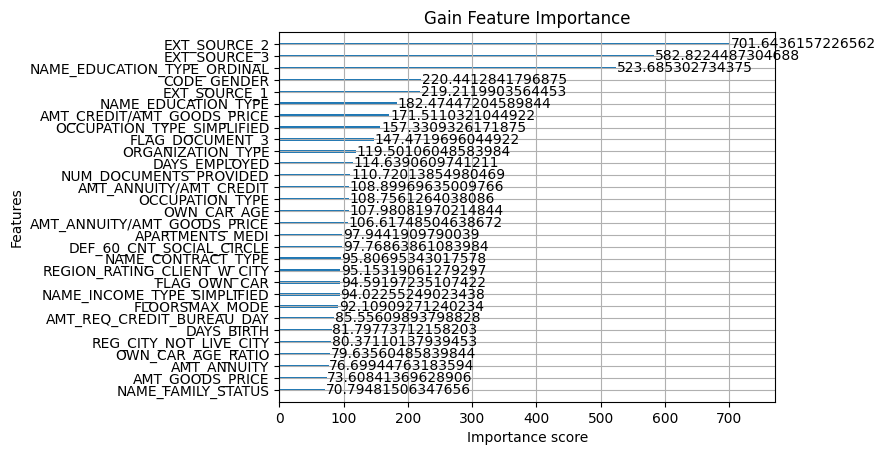

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:228: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



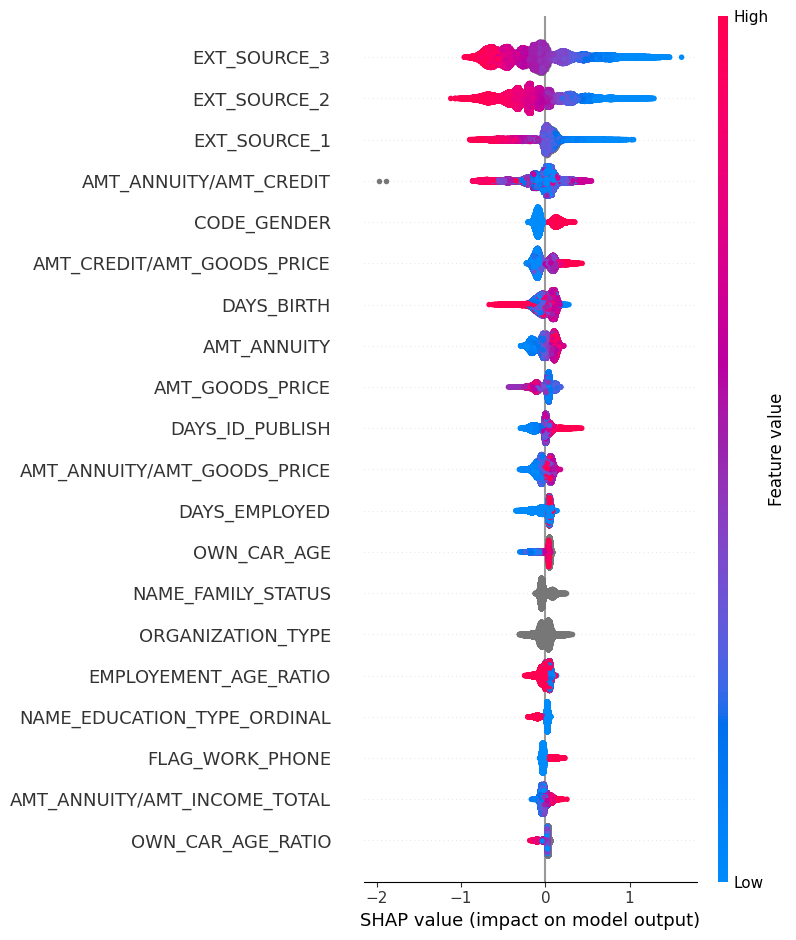

In [29]:
params = study.best_params
params.update(FIXED_PARAMS)

importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval, 
    y_trainval=y_trainval,
    X_train=X_train, 
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test, 
    submission_name="submission3", 
    seed=random_state,
    nfold=5, 
    num_boost_round=1000, 
    early_stopping_rounds=10,
    stratified=True, 
    metrics="auc",
)